# N03 - Point Cloud Representation for Parameterised Signals

In this notebooks, we create the point cloud dataset for the parameterised signals (in terms of the ($m_X$, $m_Y$) mass grid).

In [1]:
import glob
import os
basename = "/global/cfs/projectdirs/m3246/AnomalyDetection/ILC/Delphes-3.5.0/LHCO_RnD_qq_fixed"
files = glob.glob(os.path.join(basename, "*qq_*_*.txt"))
outdir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/"
all_masses = []
for filename in files:
    tokens = os.path.splitext(os.path.basename(filename))[0].split("_")
    m1, m2 = tokens[-2], tokens[-1]
    all_masses.append(f"{m1}_{m2}")

In [2]:
import numpy as np
import awkward as ak
from aliad.interface.awkward import Momentum4DArrayBuilder
from pyjet import DTYPE_PTEPM
from quickstats.utils.string_utils import split_str

def parse_RnD_qq_txt_file(filename:str, sort_by_mass:bool=True):
    event_numbers = []
    jet_indices = []
    jet_features = []
    part_features = []
    with open(filename, 'r') as f:
        data = f.readlines()
    for line in data:
        tokens = line.split()
        event_number = int(tokens[0])
        jet_index = int(tokens[1])
        jet_features_i = [float(token) for token in tokens[3:13]]
        part_features_i = [tuple(split_str(tokens, cast=float) + [0.]) \
                           for tokens in line.split('P')[1:]]
        part_features_i = np.array(part_features_i, dtype=[("pT", "float64"),
                                                           ("eta", "float64"),
                                                           ("phi", "float64"),
                                                           ("mass", "float64")])
        event_numbers.append(event_number)
        jet_indices.append(jet_index)        
        jet_features.append(jet_features_i)
        part_features.append(part_features_i)
    event_numbers = np.array(event_numbers)
    jet_indices = np.array(jet_indices)
    jet_size = np.unique(jet_indices).shape[0]
    jet_features = np.array(jet_features)
    array_builder = Momentum4DArrayBuilder('PtEtaPhiM')
    part_features = array_builder.get_array_from_list(part_features)
    record = {
        'event_number'  : event_numbers,
        'jet_index'     : jet_indices,
        'jet_features'  : jet_features,
        'part_features' : part_features
    }
    if sort_by_mass:
        sample_size = jet_features.shape[0]
        sort_idx = np.argsort(-jet_features[:, 3].reshape(sample_size//jet_size, jet_size), axis=-1)
        sort_idx = sort_idx + np.arange(sample_size//jet_size).reshape(sample_size//jet_size, 1) * jet_size
        sort_idx = sort_idx.flatten()
        for key in ['jet_features', 'part_features']:
            record[key] = record[key][sort_idx]
    record = ak.Record(record)
    return record

In [4]:
data = {}
save = True
cache = True
for filename in files:
    tokens = os.path.splitext(os.path.basename(filename))[0].split("_")
    m1, m2 = tokens[-2], tokens[-1]
    basename = os.path.basename(filename)
    outname = os.path.join(outdir, "row_based", f"point_cloud_W_qq_{m1}_{m2}.parquet")
    print(f'INFO: Working on m1 = {m1}, m2 = {m2}')
    if (not cache) or (not os.path.exists(outname)):
        print(f'INFO: Parsing file "{basename}"')
        data[f"{m1}_{m2}"] = parse_RnD_qq_txt_file(filename)
        if save:
            print(f'INFO: Saving output to "{outname}"')
            ak.to_parquet(data[f"{m1}_{m2}"], outname)
    else:
        print(f'INFO: Cached output from "{outname}"')
        data[f"{m1}_{m2}"] = ak.from_parquet(outname)

INFO: Working on m1 = 100, m2 = 500
INFO: Parsing file "LHCO_RnD_qq_100_500.txt"
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/row_based/point_cloud_W_qq_100_500.parquet"
INFO: Working on m1 = 300, m2 = 100
INFO: Parsing file "LHCO_RnD_qq_300_100.txt"
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/row_based/point_cloud_W_qq_300_100.parquet"
INFO: Working on m1 = 350, m2 = 350
INFO: Parsing file "LHCO_RnD_qq_350_350.txt"
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/row_based/point_cloud_W_qq_350_350.parquet"
INFO: Working on m1 = 400, m2 = 400
INFO: Parsing file "LHCO_RnD_qq_400_400.txt"
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/row_based/point_cloud_W_qq_400_400.parquet"
INFO: Working on m1 = 250, m2 = 50
INFO: Parsing file "LHCO_RnD_qq_250_50.txt"
INFO:

### Validation: Comparison of jet pT from jet-level and constituent-level information

[INFO] Using deduced bin range (20.052, 3157.362)


<Figure size 640x480 with 0 Axes>

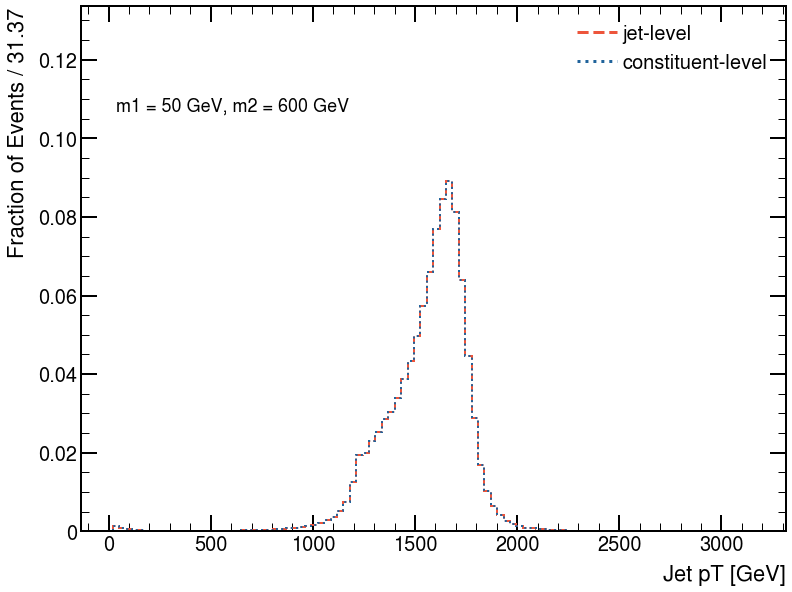

[INFO] Using deduced bin range (-0.010, 0.010)


<Figure size 640x480 with 0 Axes>

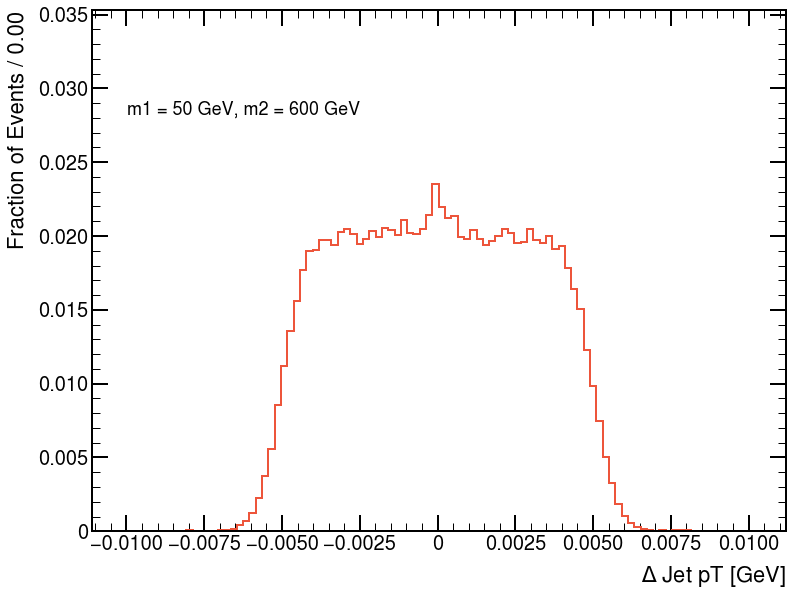

[INFO] Using deduced bin range (20.052, 3157.362)


<Figure size 640x480 with 0 Axes>

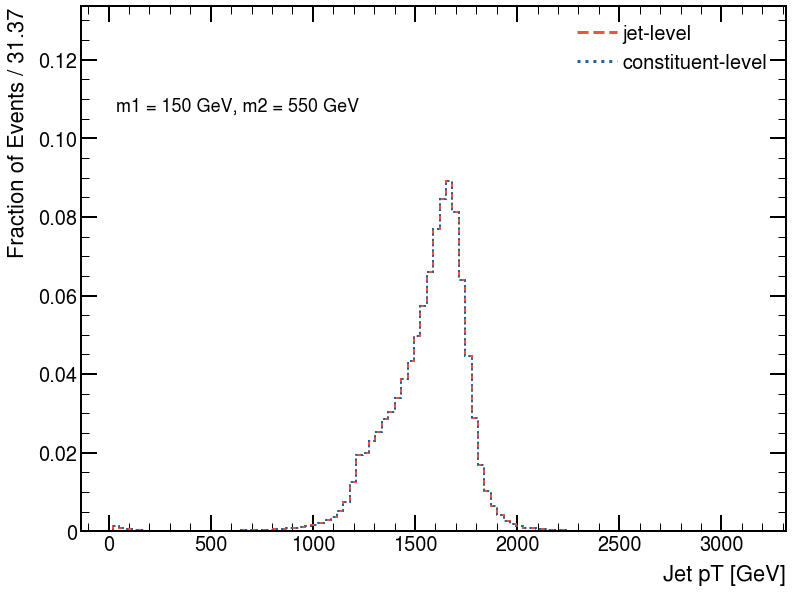

[INFO] Using deduced bin range (-0.010, 0.010)


<Figure size 640x480 with 0 Axes>

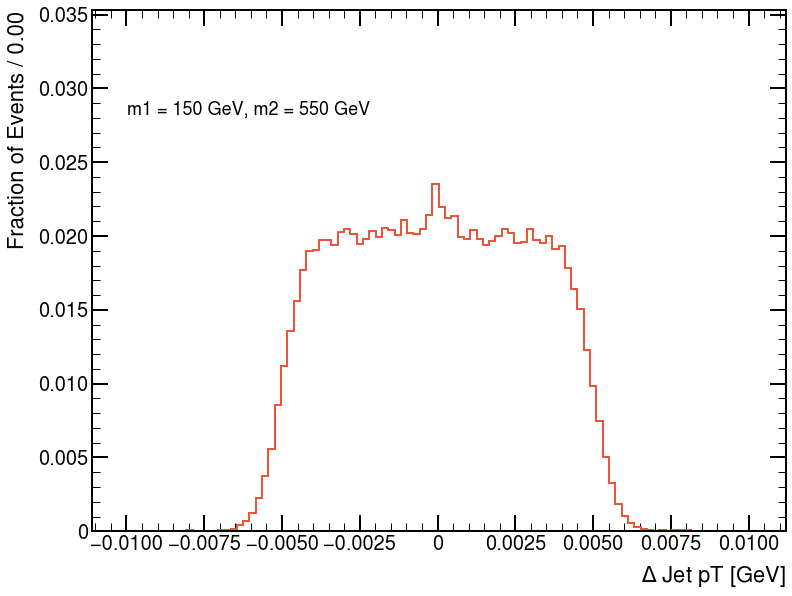

[INFO] Using deduced bin range (20.052, 3157.362)


<Figure size 640x480 with 0 Axes>

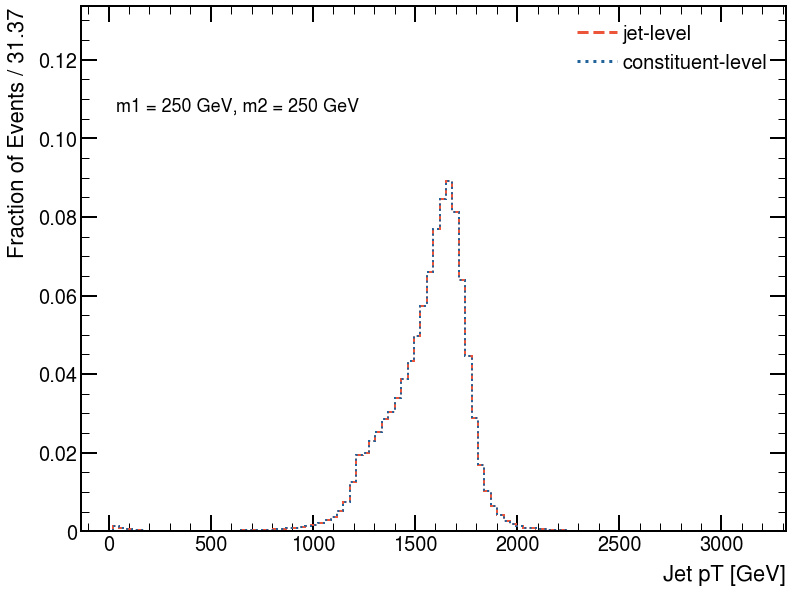

[INFO] Using deduced bin range (-0.010, 0.010)


<Figure size 640x480 with 0 Axes>

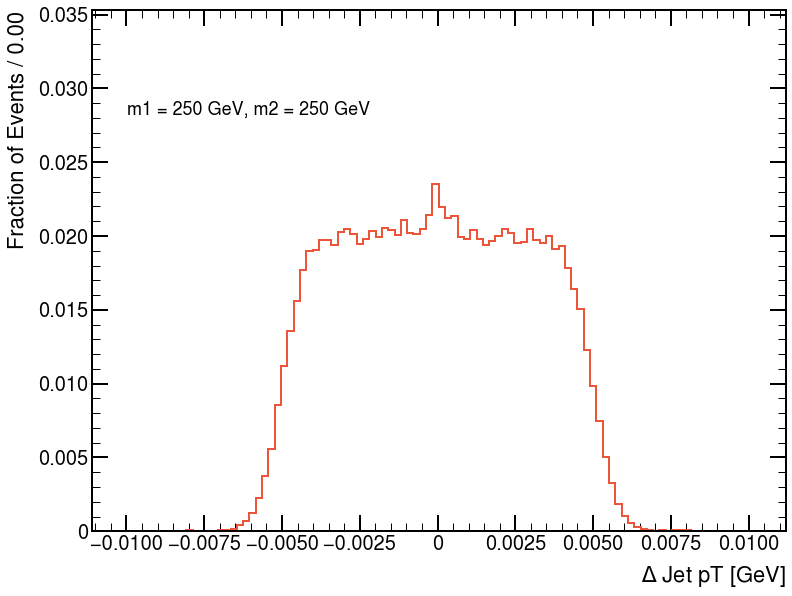

[INFO] Using deduced bin range (20.052, 3157.362)


<Figure size 640x480 with 0 Axes>

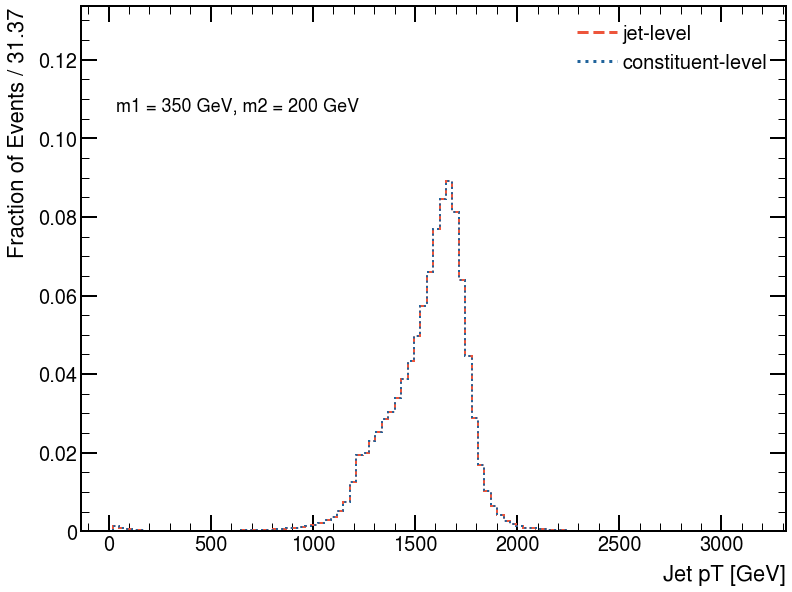

[INFO] Using deduced bin range (-0.010, 0.010)


<Figure size 640x480 with 0 Axes>

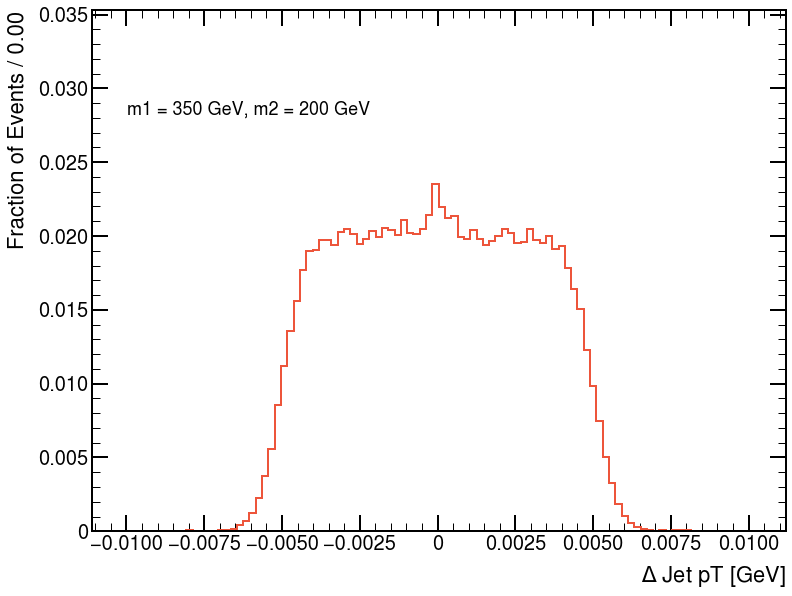

In [30]:
from quickstats.plots import VariableDistributionPlot
from quickstats.plots.template import create_transform
import pandas as pd
import matplotlib.pyplot as plt
mass_points = ["50_600", "150_550", "250_250", "350_200"]
for masses in mass_points:
    m1, m2 = masses.split('_')
    jet_p4 = ak.sum(data['150_550']['part_features'], axis=1)
    dfs = {
        'jet'  : pd.DataFrame({"pt": data['150_550']['jet_features'][:, 0]}),
        'part' : pd.DataFrame({"pt": jet_p4.pt})
    }
    df = pd.DataFrame({"delta_pt": dfs["jet"]["pt"].values - dfs["part"]["pt"].values})
    label_map = {
        'jet': 'jet-level',
        'part': 'constituent-level'
    }
    plot_options = {
        'jet': {
            'styles': {
                'linestyle': 'dashed'
            }
        },
        'part': {
            'styles': {
                'linestyle': 'dotted'
            }
        }, 
    }
    plotter = VariableDistributionPlot(dfs, plot_options=plot_options, label_map=label_map)
    ax = plotter.draw('pt', xlabel='Jet pT [GeV]', bins=100)
    transform = create_transform('axis', 'axis')
    ax.text(0.05, 0.8, f'm1 = {m1} GeV, m2 = {m2} GeV', transform=transform, fontsize=18)
    plt.show()
    plotter = VariableDistributionPlot(df)
    ax = plotter.draw('delta_pt', xlabel='$\Delta$ Jet pT [GeV]', bins=100)
    transform = create_transform('axis', 'axis')
    ax.text(0.05, 0.8, f'm1 = {m1} GeV, m2 = {m2} GeV', transform=transform, fontsize=18)
    plt.show()

In [33]:
def get_feature_array(data, njet:int=2):
    array = {}
    for jet_index in range(njet):
        jet_key = f'j{jet_index+1}'
        jet_mask = data['jet_index'] == jet_index
        jet_features = data['jet_features'][jet_mask]
        part_features = data['part_features'][jet_mask]
        array[jet_key] = {}
        # jet features
        array[jet_key]["jet_pt"]   = jet_features[:, 0] / 1000.
        array[jet_key]["jet_eta"]  = jet_features[:, 1]
        array[jet_key]["jet_phi"]  = jet_features[:, 2]
        array[jet_key]["jet_m"]    = jet_features[:, 3] / 1000.
        array[jet_key]["jet_btag"] = jet_features[:, 4]
        array[jet_key]["N"]        = ak.count(part_features, axis=-1)
        for i in range(5):
            array[jet_key][f'tau{i+1}'] = jet_features[:, 5 + i]
        tau_mask = ((jet_features[:, 5] > 0) & (jet_features[:, 6] > 0))
        array[jet_key]['tau12'] = np.where(tau_mask, np.divide(jet_features[:, 6],
                                                               jet_features[:, 5], where=tau_mask), 0)
        array[jet_key]['tau23'] = np.where(tau_mask, np.divide(jet_features[:, 7],
                                                               jet_features[:, 6], where=tau_mask), 0)
        jet_p4 = Momentum4DArrayBuilder.get_array_from_dict({
            'pt'  : jet_features[:, 0],
            'eta' : jet_features[:, 1],
            'phi' : jet_features[:, 2],
            'm'   : jet_features[:, 3]})
        # particle features
        array[jet_key]['part_pt']        = part_features.pt / 1000.
        array[jet_key]['part_eta']       = part_features.eta
        array[jet_key]['part_phi']       = part_features.phi
        array[jet_key]['part_e']         = part_features.e / 1000.
        array[jet_key]['part_rel_pt']    = part_features.pt / jet_p4.pt
        array[jet_key]['part_delta_eta'] = part_features.deltaeta(jet_p4)
        array[jet_key]['part_delta_phi'] = part_features.deltaphi(jet_p4)
        array[jet_key]['part_delta_R']   = part_features.deltaR(jet_p4)
    
    ak_array = ak.Array(array)
    # evaluate mjj
    j1_p4 = ak.zip({
    "pt"  : ak_array["j1"]["jet_pt"],
    "eta" : ak_array["j1"]["jet_eta"],
    "phi" : ak_array["j1"]["jet_phi"],
    "m"   : ak_array["j1"]["jet_m"]
    }, with_name="Momentum4D")
    j2_p4 = ak.zip({
        "pt"  : ak_array["j2"]["jet_pt"],
        "eta" : ak_array["j2"]["jet_eta"],
        "phi" : ak_array["j2"]["jet_phi"],
        "m"   : ak_array["j2"]["jet_m"]
    }, with_name="Momentum4D")
    jj_p4 = j1_p4.add(j2_p4)
    ak_array['jj'] = ak.Array({'mjj': jj_p4.m,
                               'jj_pt': jj_p4.pt})
    return ak_array

In [37]:
feature_arrays = {}
cache = False
save = True
masses_to_keep  = ["500_100", "350_350", "50_400"]
#masses_to_keep = all_masses
for masses in all_masses:
    m1, m2 = masses.split("_")
    outname = os.path.join(outdir, "col_based", f"point_cloud_W_qq_{m1}_{m2}.parquet")
    print(f'INFO: Working on m1 = {m1}, m2 = {m2}')
    if masses == "100_250":
        cache=False
    if (not cache) or (not os.path.exists(outname)):
        print(f'INFO: Converting arrays')
        feature_arrays[masses] = get_feature_array(data[masses], njet=2)
        # free memory
        data[masses] = None
        if save:
            print(f'INFO: Saving output to "{outname}"')
            ak.to_parquet(feature_arrays[masses], outname)
        if masses not in masses_to_keep:
            feature_arrays[masses] = None
    elif masses in masses_to_keep:
        print(f'INFO: Cached output from "{outname}"')
        feature_arrays[masses] = ak.from_parquet(outname)

INFO: Working on m1 = 100, m2 = 500
INFO: Converting arrays
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/point_cloud_W_qq_100_500.parquet"
INFO: Working on m1 = 300, m2 = 100
INFO: Converting arrays
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/point_cloud_W_qq_300_100.parquet"
INFO: Working on m1 = 350, m2 = 350
INFO: Converting arrays
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/point_cloud_W_qq_350_350.parquet"
INFO: Working on m1 = 400, m2 = 400
INFO: Converting arrays
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/point_cloud_W_qq_400_400.parquet"
INFO: Working on m1 = 250, m2 = 50
INFO: Converting arrays
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_b

Apply Signal Region selection

In [39]:
feature_arrays = {}
cache = False
save = True
masses_to_keep = ["500_100", "350_350", "50_400"]
for masses in all_masses:
    m1, m2 = masses.split("_")
    input_path = os.path.join(outdir, "col_based", f"point_cloud_W_qq_{m1}_{m2}.parquet")
    outname = os.path.join(outdir, "col_based", f"SR_point_cloud_W_qq_{m1}_{m2}.parquet")
    print(f'INFO: Working on m1 = {m1}, m2 = {m2}')
    if (not cache) or (not os.path.exists(outname)):
        data = ak.from_parquet(input_path)
        print(f'INFO: Applying SR selection')
        mjj = data['jj']['mjj']
        SR_mask = np.where((mjj >3.3) & (mjj < 3.7))
        feature_arrays[masses] = data[SR_mask]
        if save:
            print(f'INFO: Saving output to "{outname}"')
            ak.to_parquet(feature_arrays[masses], outname)
        if masses not in masses_to_keep:
            feature_arrays[masses] = None
    elif masses in masses_to_keep:
        print(f'INFO: Cached output from "{outname}"')
        feature_arrays[masses] = ak.from_parquet(outname)

INFO: Working on m1 = 100, m2 = 500
INFO: Applying SR selection
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/SR_point_cloud_W_qq_100_500.parquet"
INFO: Working on m1 = 300, m2 = 100
INFO: Applying SR selection
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/SR_point_cloud_W_qq_300_100.parquet"
INFO: Working on m1 = 350, m2 = 350
INFO: Applying SR selection
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/SR_point_cloud_W_qq_350_350.parquet"
INFO: Working on m1 = 400, m2 = 400
INFO: Applying SR selection
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_RnD_qq/col_based/SR_point_cloud_W_qq_400_400.parquet"
INFO: Working on m1 = 250, m2 = 50
INFO: Applying SR selection
INFO: Saving output to "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC

In [41]:
import os
basedir = "/pscratch/sd/c/chlcheng/dataset/anomaly_detection/LHC_Olympics_2020/LHCO_qq"
filename = os.path.join(basedir, "col_based", "SR_point_cloud_W_qq_500_100_official.parquet")
feature_arrays["500_100_LHCO"] = ak.from_parquet(filename)

In [42]:
import pandas as pd
from quickstats.plots import VariableDistributionPlot
dfs = {}
for masses in (masses_to_keep + ["500_100_LHCO"]):
    data = {
        "lead_jet_pt"    : np.array(feature_arrays[masses]["j1"]["jet_pt"]),
        "lead_jet_eta"   : np.array(feature_arrays[masses]["j1"]["jet_eta"]),
        "lead_jet_phi"   : np.array(feature_arrays[masses]["j1"]["jet_phi"]),
        "lead_jet_m"     : np.array(feature_arrays[masses]["j1"]["jet_m"]),
        "lead_jet_N"     : np.array(feature_arrays[masses]["j1"]["N"]),
        "lead_jet_tau1"  : np.array(feature_arrays[masses]["j1"]["tau1"]),
        "lead_jet_tau2"  : np.array(feature_arrays[masses]["j1"]["tau2"]),
        "lead_jet_tau3"  : np.array(feature_arrays[masses]["j1"]["tau3"]),
        "lead_jet_tau12" : np.array(feature_arrays[masses]["j1"]["tau12"]),
        "lead_jet_tau23" : np.array(feature_arrays[masses]["j1"]["tau23"]),
        "sub_jet_pt"     : np.array(feature_arrays[masses]["j2"]["jet_pt"]),
        "sub_jet_eta"    : np.array(feature_arrays[masses]["j2"]["jet_eta"]),
        "sub_jet_phi"    : np.array(feature_arrays[masses]["j2"]["jet_phi"]),
        "sub_jet_m"      : np.array(feature_arrays[masses]["j2"]["jet_m"]),
        "sub_jet_N"      : np.array(feature_arrays[masses]["j2"]["N"]),
        "sub_jet_tau1"   : np.array(feature_arrays[masses]["j2"]["tau1"]),
        "sub_jet_tau2"   : np.array(feature_arrays[masses]["j2"]["tau2"]),
        "sub_jet_tau3"   : np.array(feature_arrays[masses]["j2"]["tau3"]),
        "sub_jet_tau12"  : np.array(feature_arrays[masses]["j2"]["tau12"]),
        "sub_jet_tau23"  : np.array(feature_arrays[masses]["j2"]["tau23"]),
        "mjj"            : np.array(feature_arrays[masses]["jj"]["mjj"])
    }
    dfs[masses] = pd.DataFrame(data)

<Figure size 640x480 with 0 Axes>

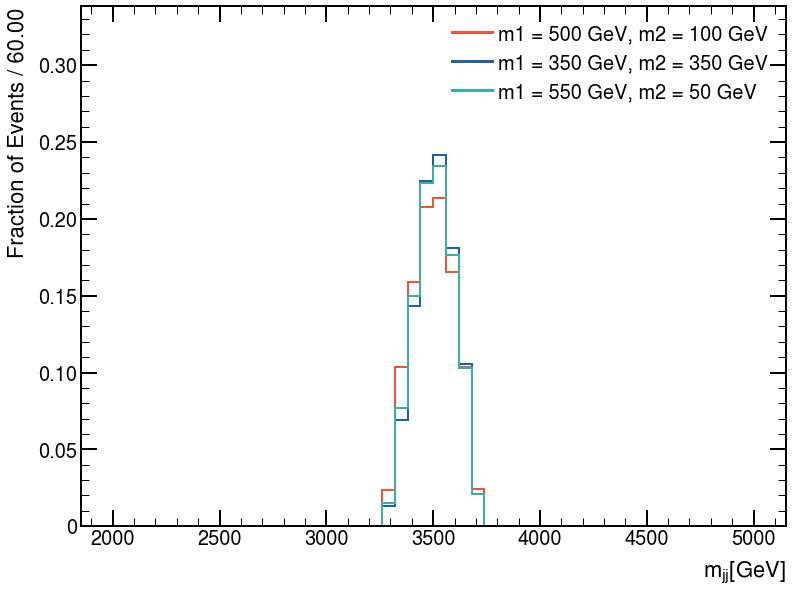

<Figure size 640x480 with 0 Axes>

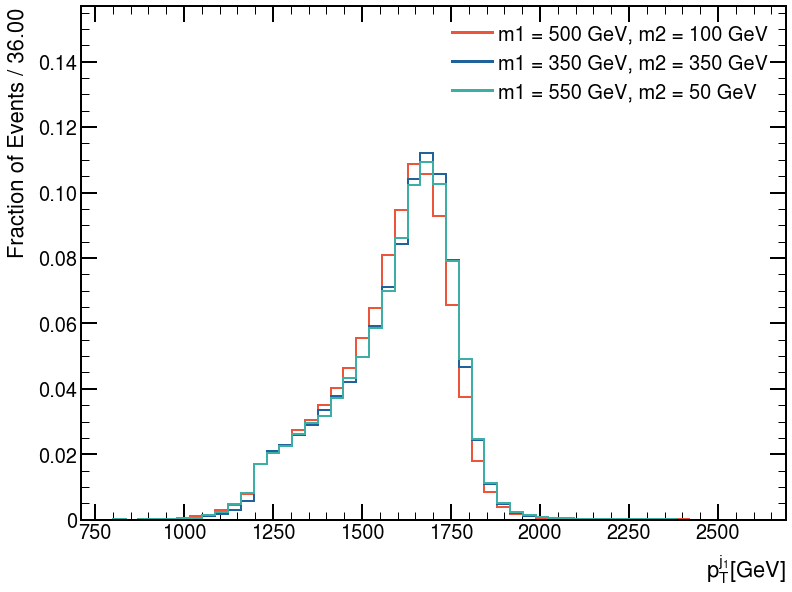

<Figure size 640x480 with 0 Axes>

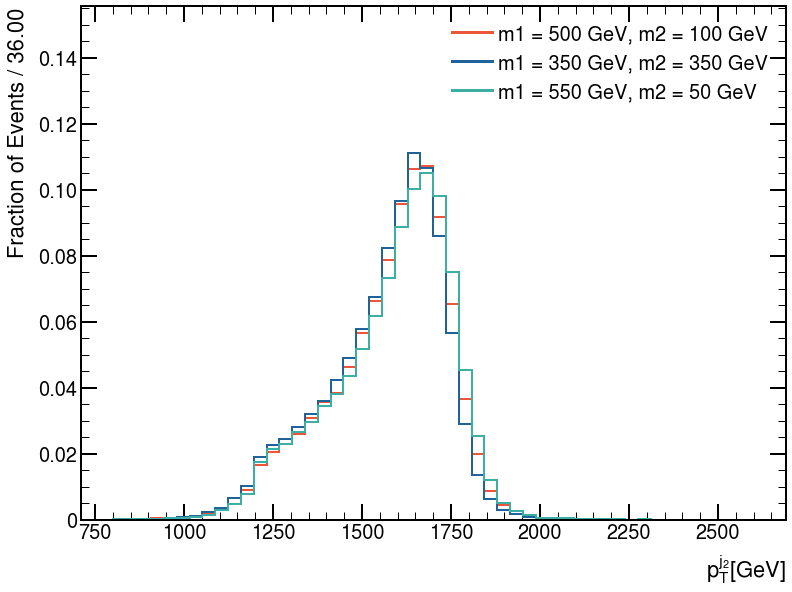

<Figure size 640x480 with 0 Axes>

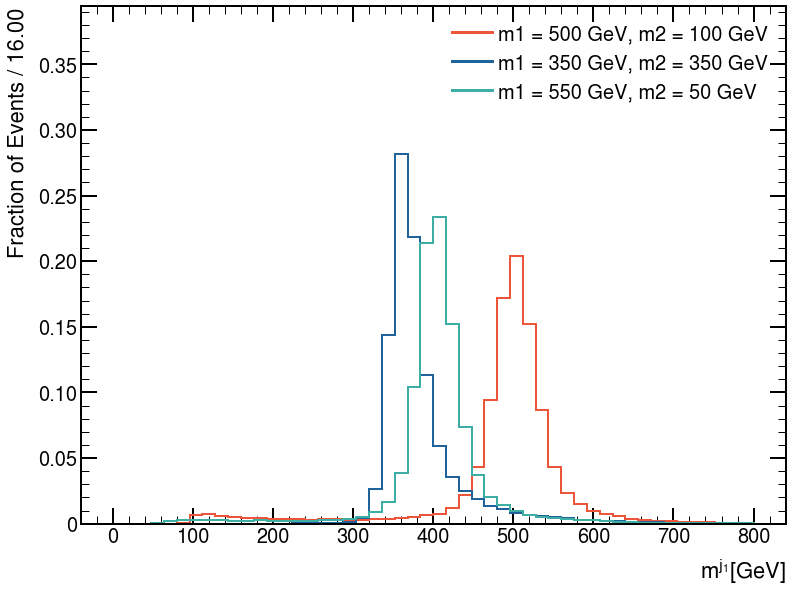

<Figure size 640x480 with 0 Axes>

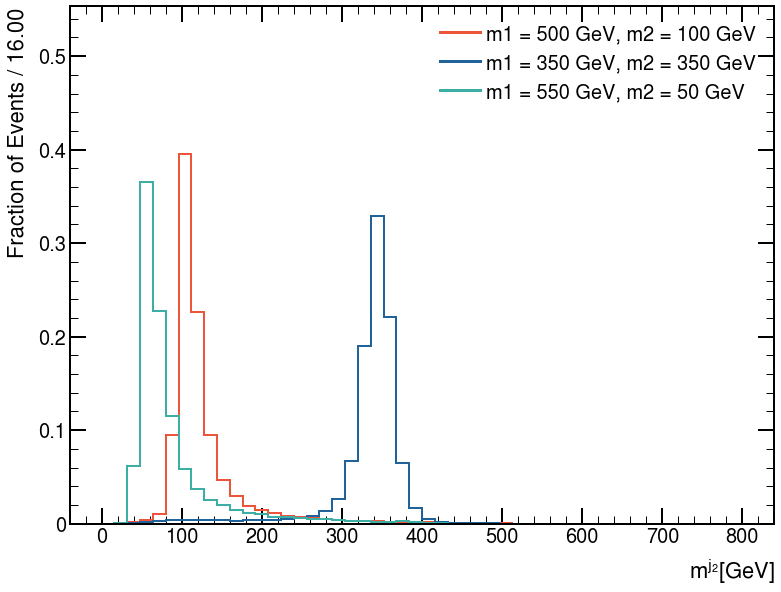

[INFO] Using deduced bin range (-2.195, 2.208)


<Figure size 640x480 with 0 Axes>

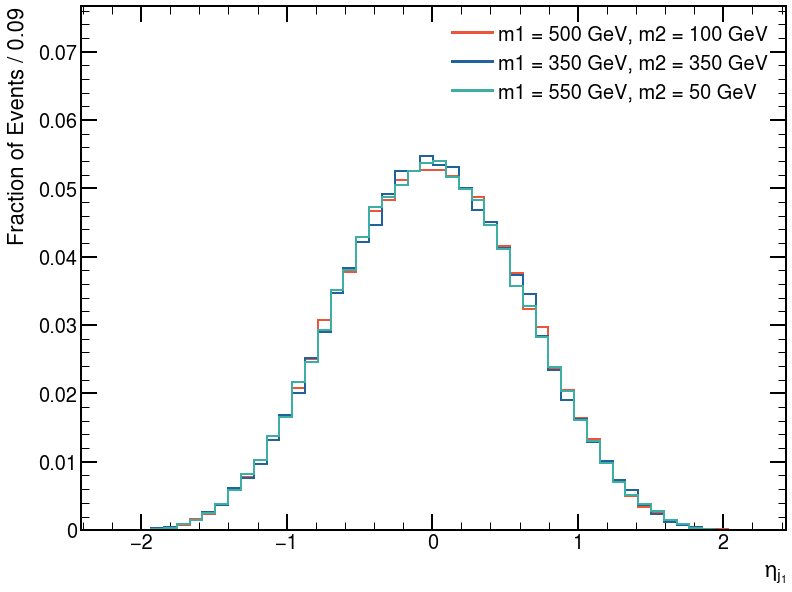

[INFO] Using deduced bin range (-2.447, 2.204)


<Figure size 640x480 with 0 Axes>

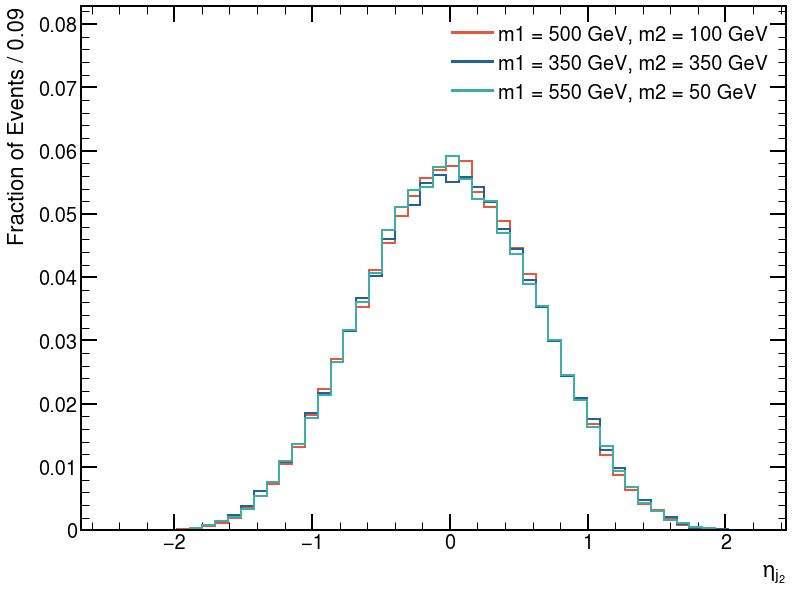

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

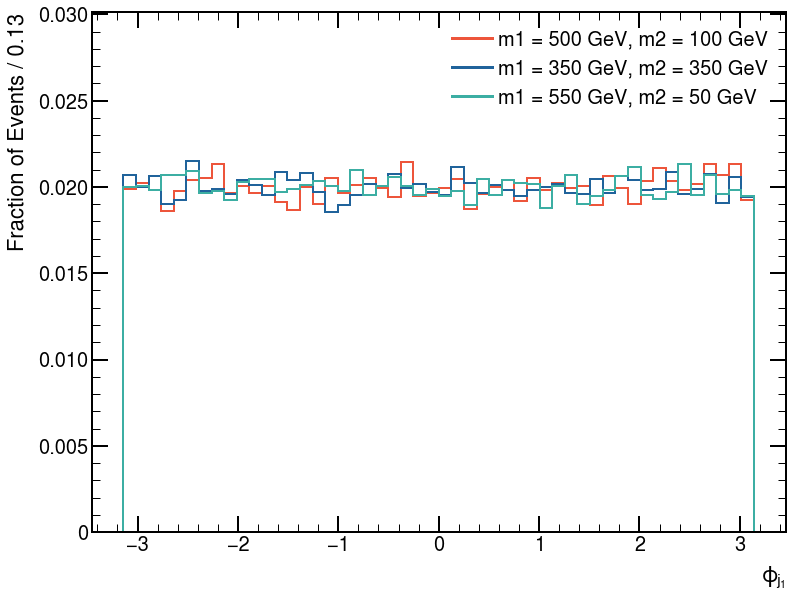

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

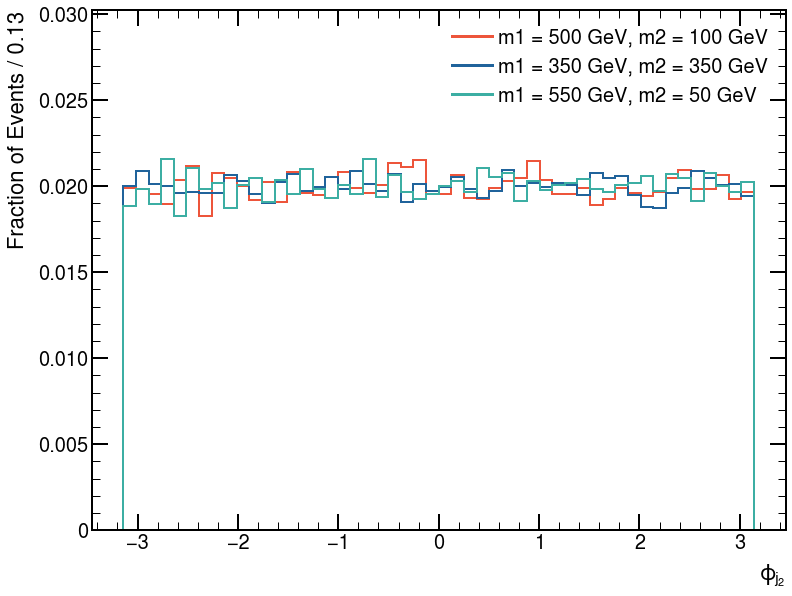

[INFO] Using deduced bin range (7.000, 191.000)


<Figure size 640x480 with 0 Axes>

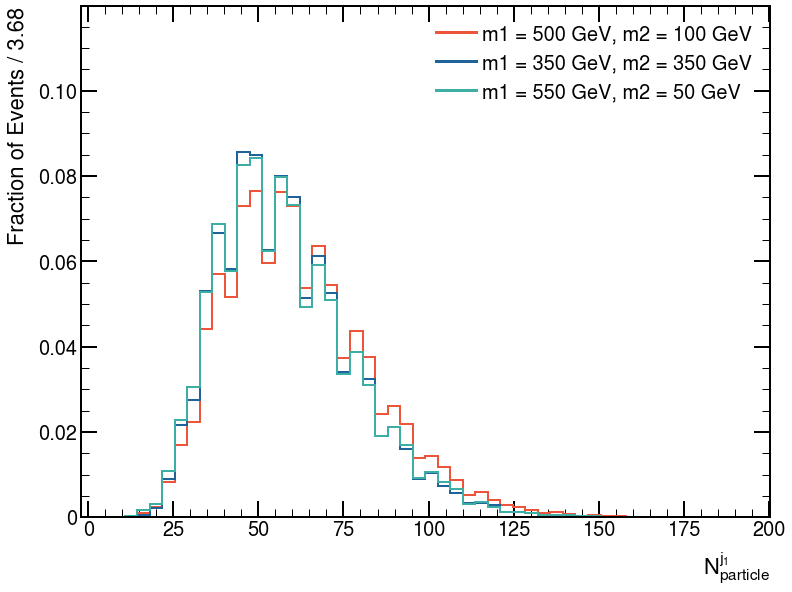

[INFO] Using deduced bin range (3.000, 160.000)


<Figure size 640x480 with 0 Axes>

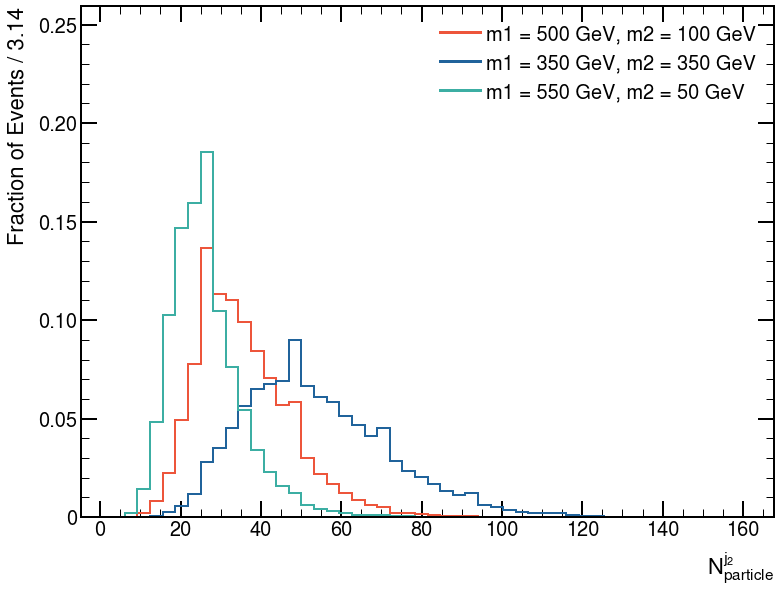

[INFO] Using deduced bin range (0.003, 0.733)


<Figure size 640x480 with 0 Axes>

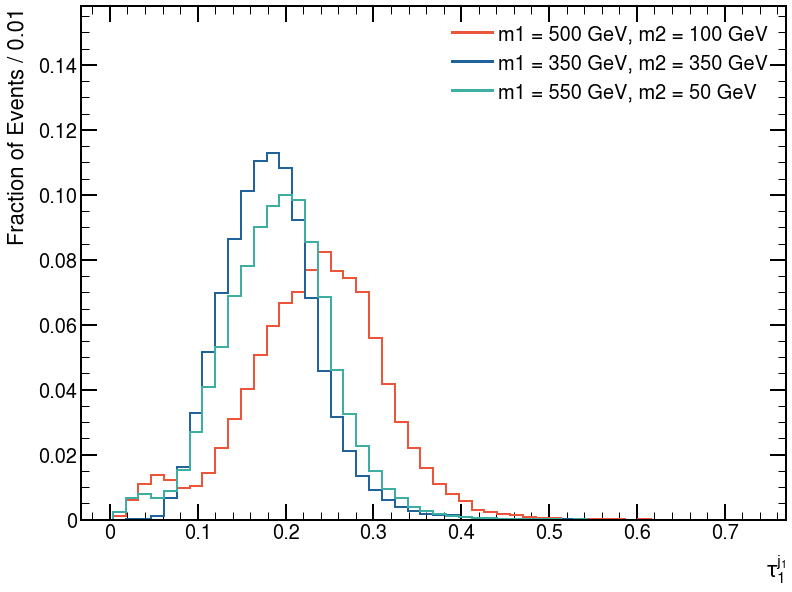

[INFO] Using deduced bin range (0.003, 0.423)


<Figure size 640x480 with 0 Axes>

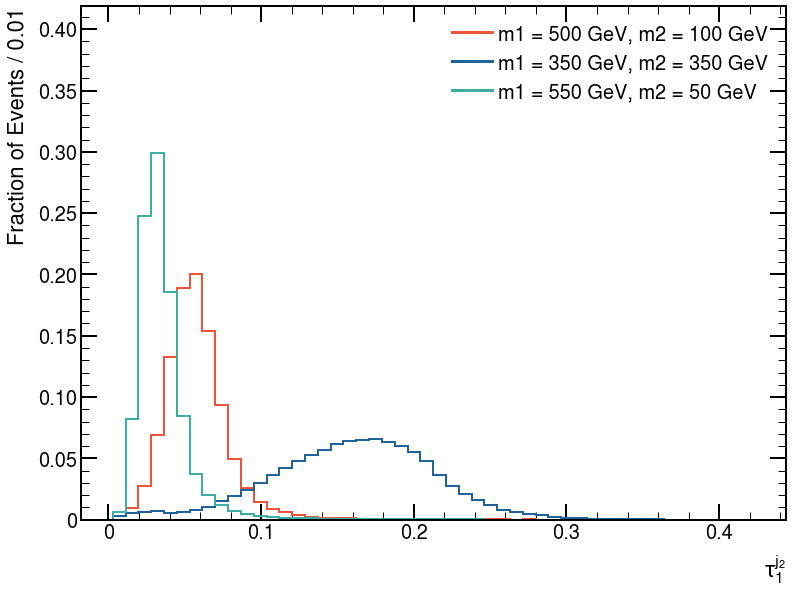

[INFO] Using deduced bin range (0.002, 0.292)


<Figure size 640x480 with 0 Axes>

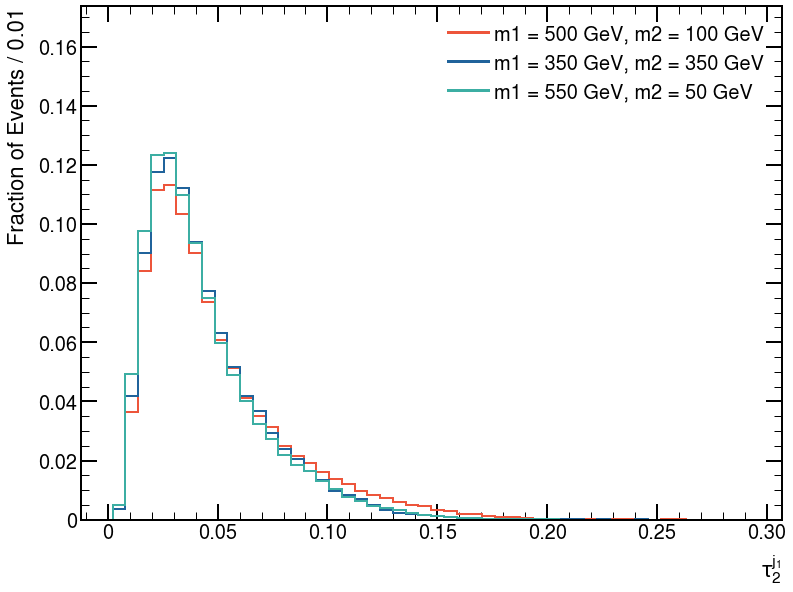

[INFO] Using deduced bin range (0.001, 0.211)


<Figure size 640x480 with 0 Axes>

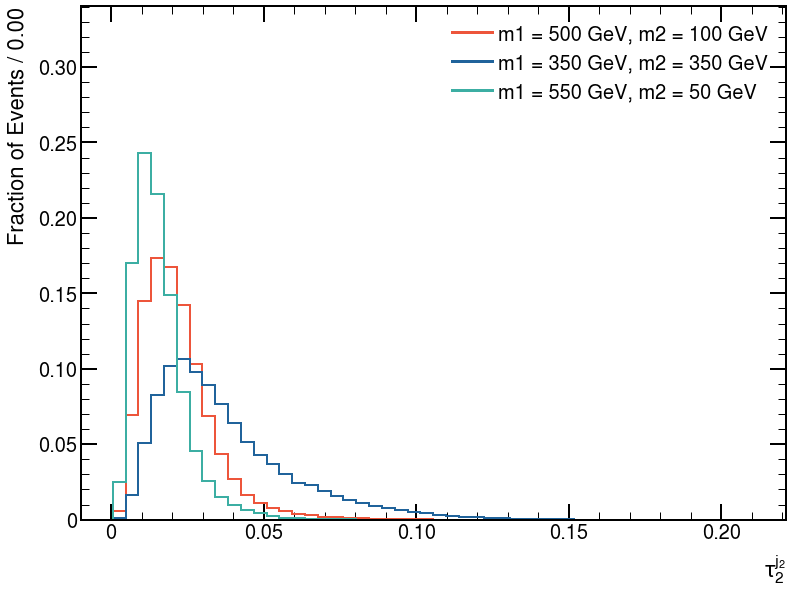

[INFO] Using deduced bin range (0.001, 0.174)


<Figure size 640x480 with 0 Axes>

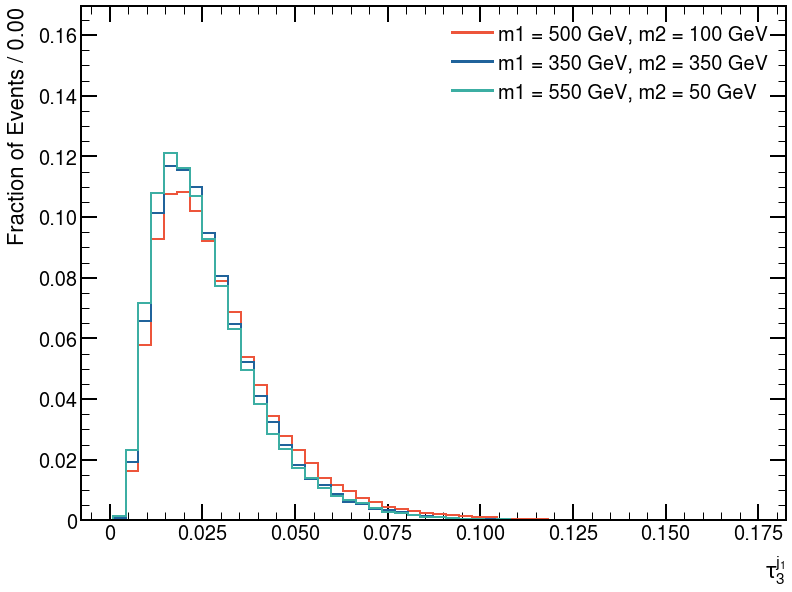

[INFO] Using deduced bin range (0.000, 0.123)


<Figure size 640x480 with 0 Axes>

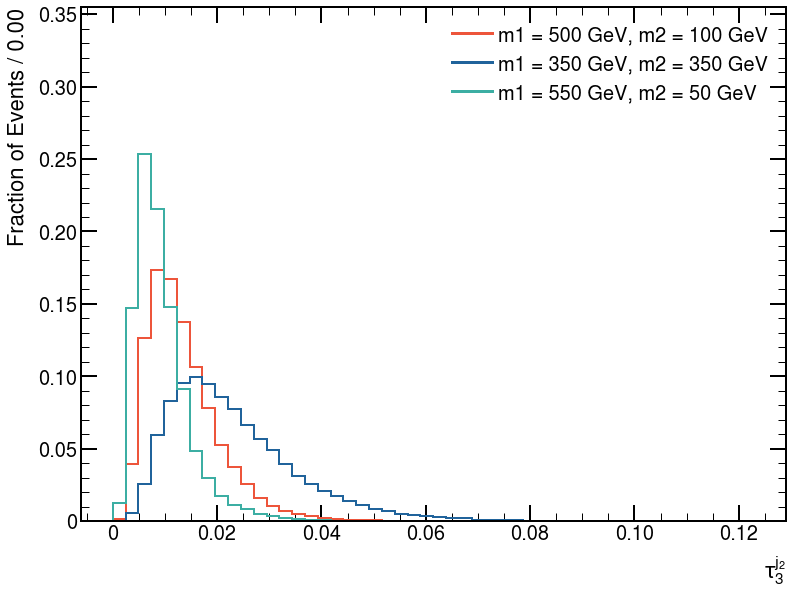

[INFO] Using deduced bin range (0.017, 0.879)


<Figure size 640x480 with 0 Axes>

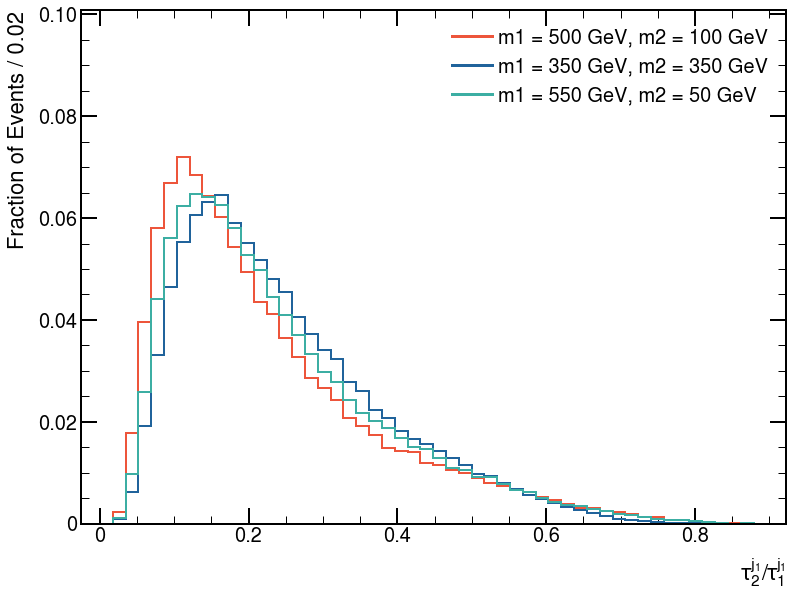

[INFO] Using deduced bin range (0.018, 0.908)


<Figure size 640x480 with 0 Axes>

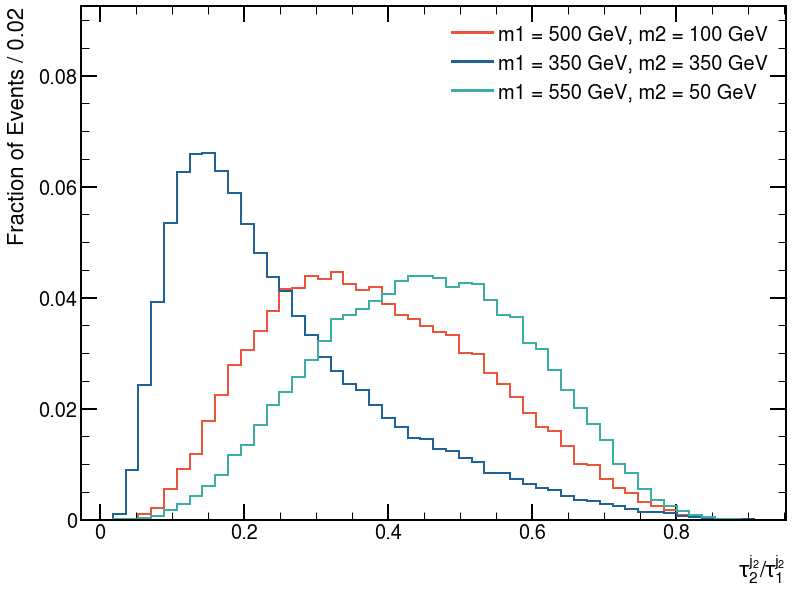

[INFO] Using deduced bin range (0.074, 0.947)


<Figure size 640x480 with 0 Axes>

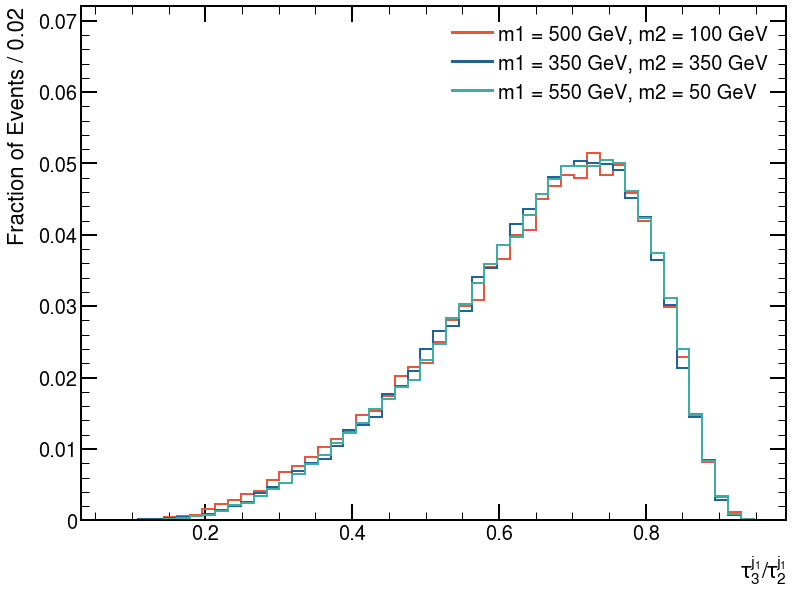

[INFO] Using deduced bin range (0.000, 0.950)


<Figure size 640x480 with 0 Axes>

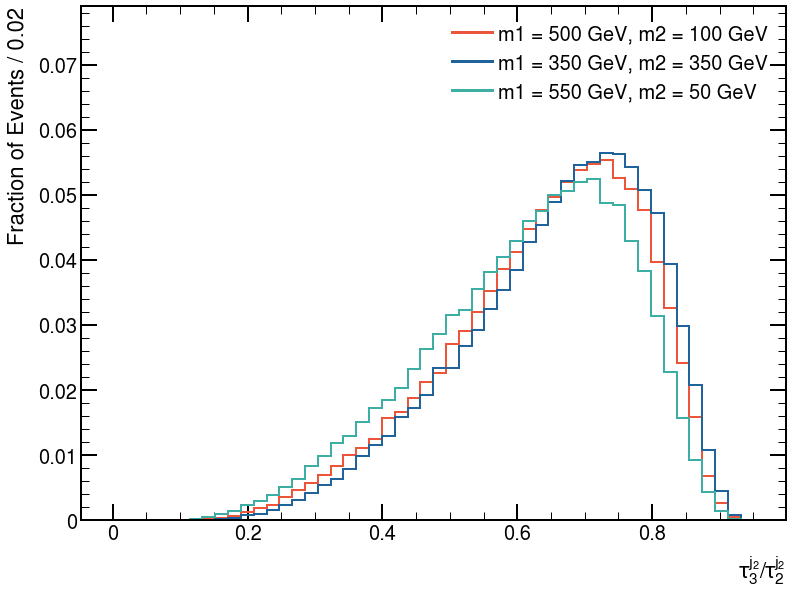

<Figure size 640x480 with 0 Axes>

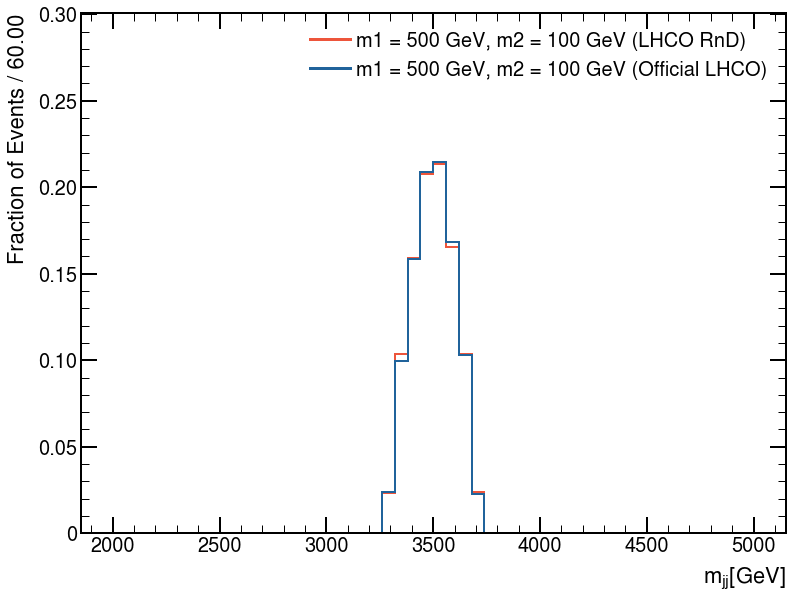

<Figure size 640x480 with 0 Axes>

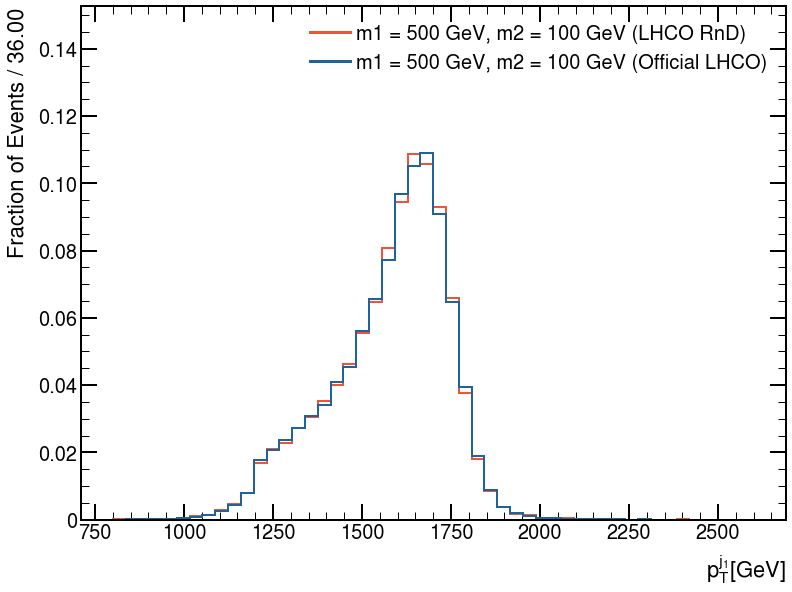

<Figure size 640x480 with 0 Axes>

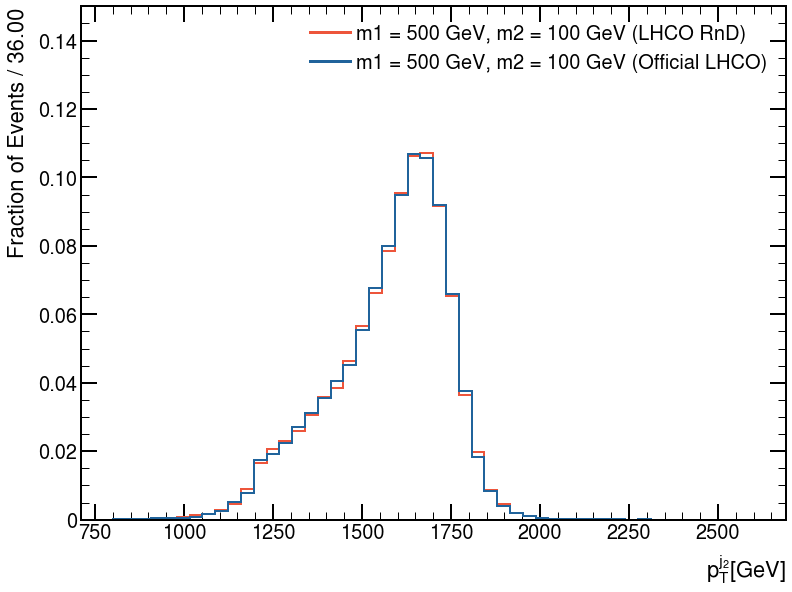

<Figure size 640x480 with 0 Axes>

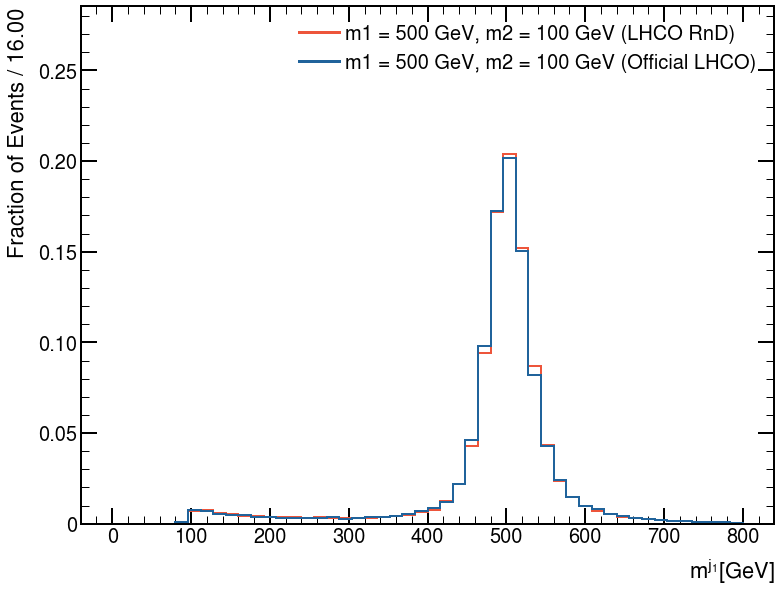

<Figure size 640x480 with 0 Axes>

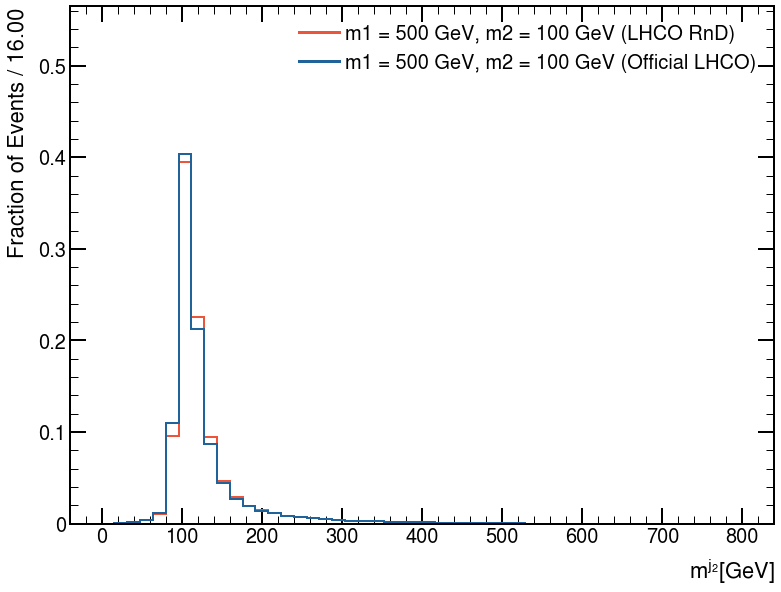

[INFO] Using deduced bin range (-2.134, 2.112)


<Figure size 640x480 with 0 Axes>

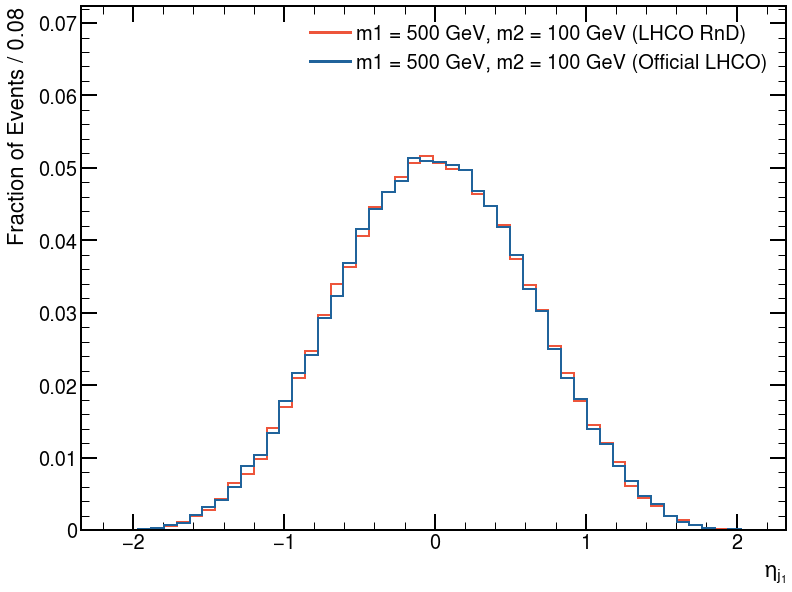

[INFO] Using deduced bin range (-2.326, 2.179)


<Figure size 640x480 with 0 Axes>

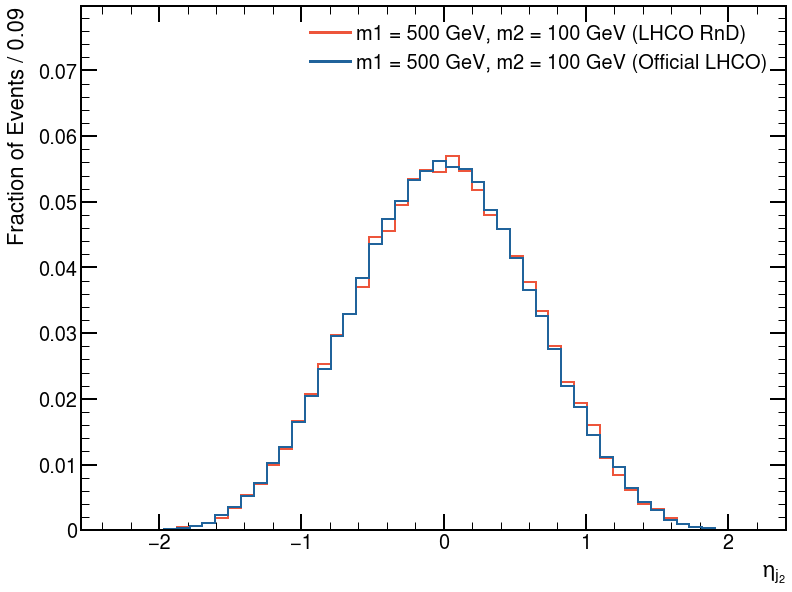

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

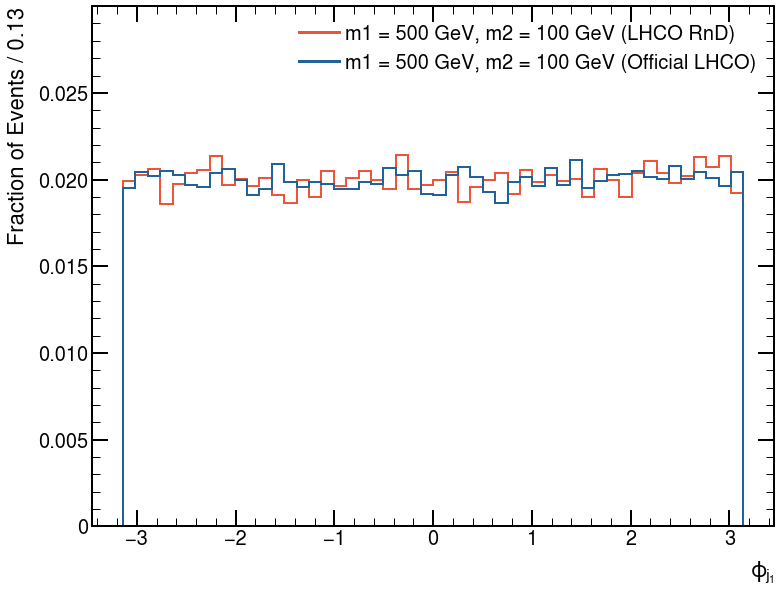

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

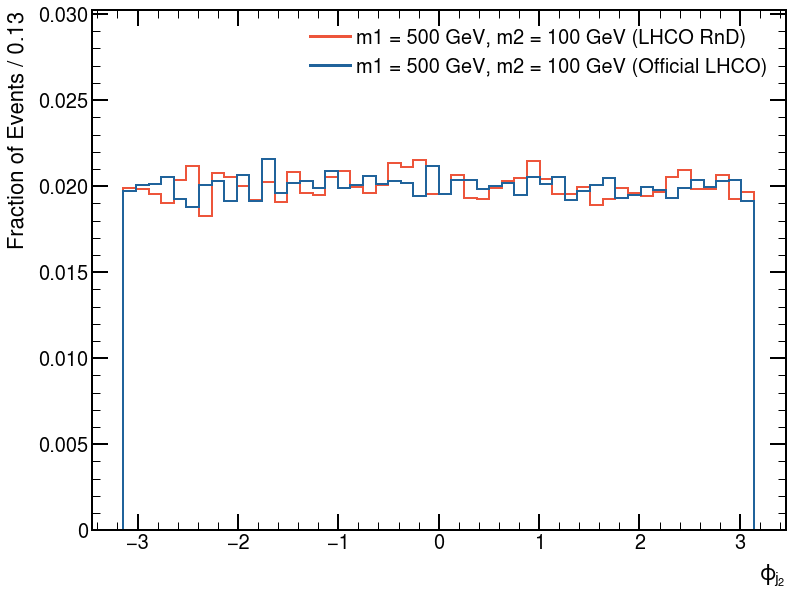

[INFO] Using deduced bin range (12.000, 190.000)


<Figure size 640x480 with 0 Axes>

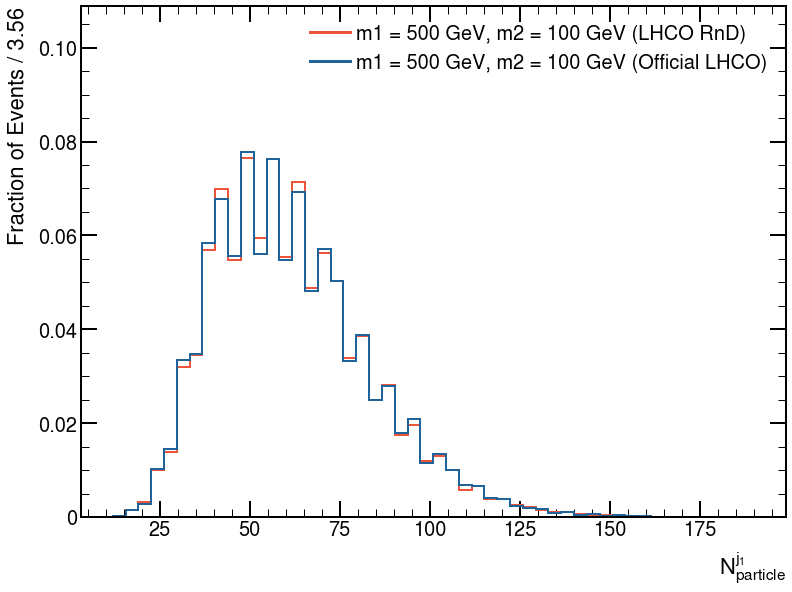

[INFO] Using deduced bin range (4.000, 175.000)


<Figure size 640x480 with 0 Axes>

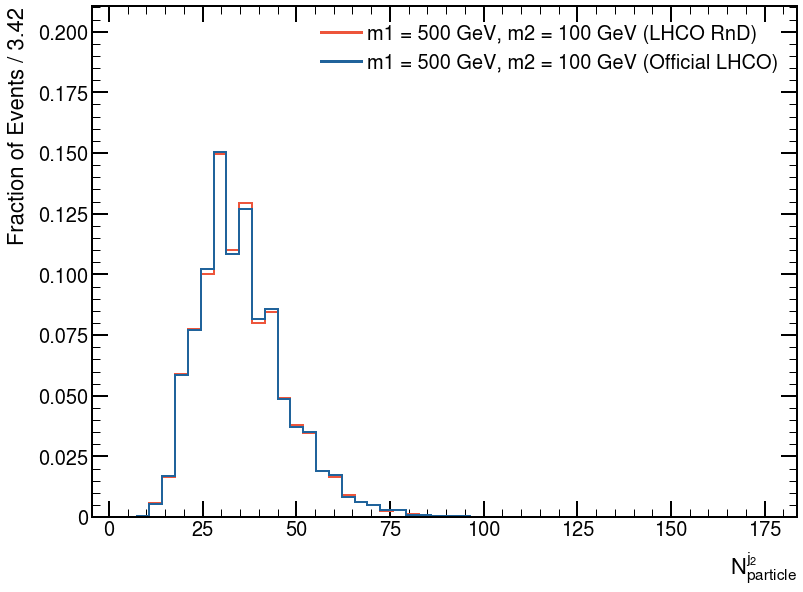

[INFO] Using deduced bin range (0.009, 1151.050)


<Figure size 640x480 with 0 Axes>

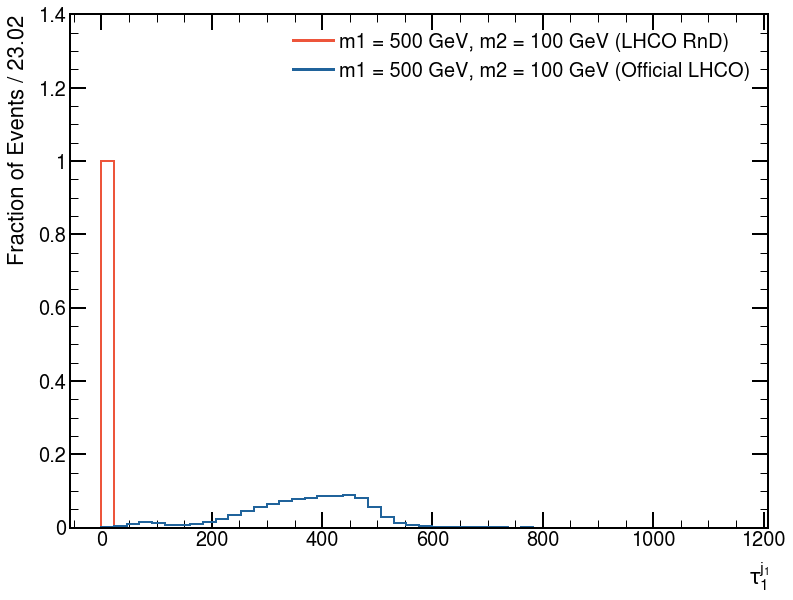

[INFO] Using deduced bin range (0.003, 681.842)


<Figure size 640x480 with 0 Axes>

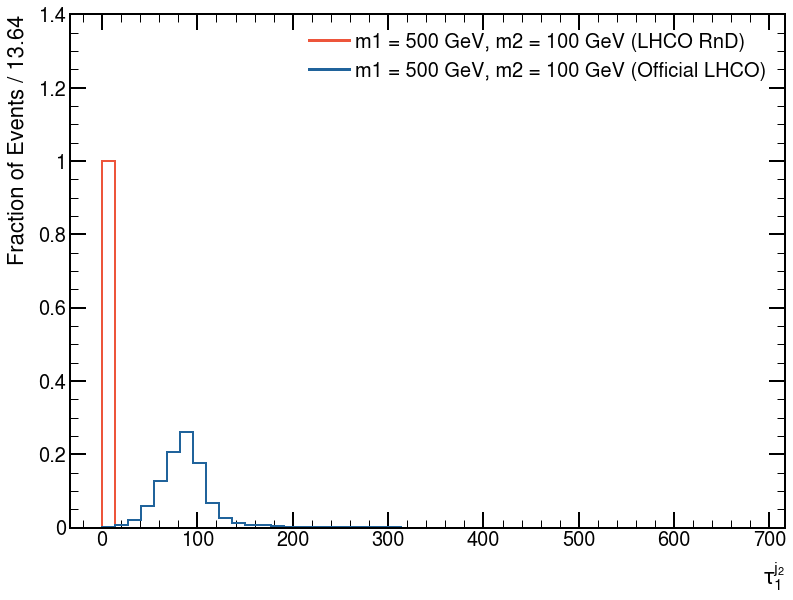

[INFO] Using deduced bin range (0.003, 521.916)


<Figure size 640x480 with 0 Axes>

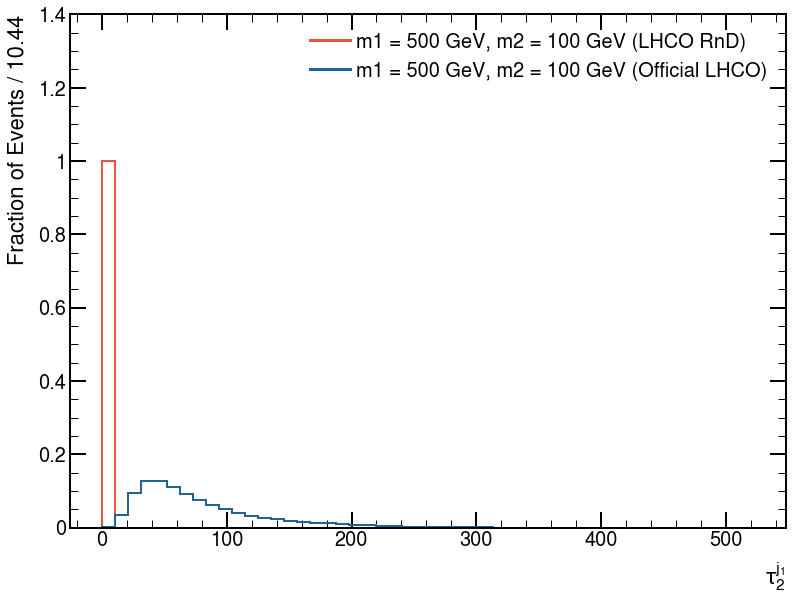

[INFO] Using deduced bin range (0.002, 248.643)


<Figure size 640x480 with 0 Axes>

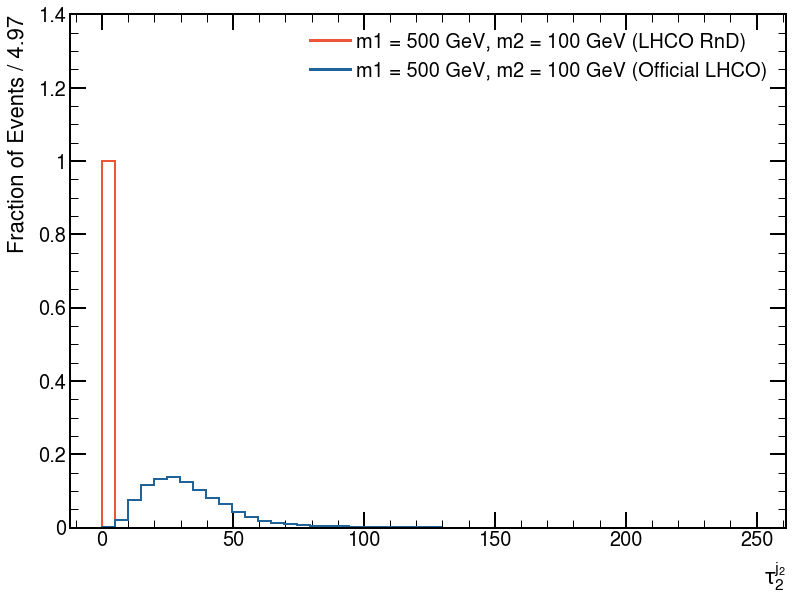

[INFO] Using deduced bin range (0.002, 272.331)


<Figure size 640x480 with 0 Axes>

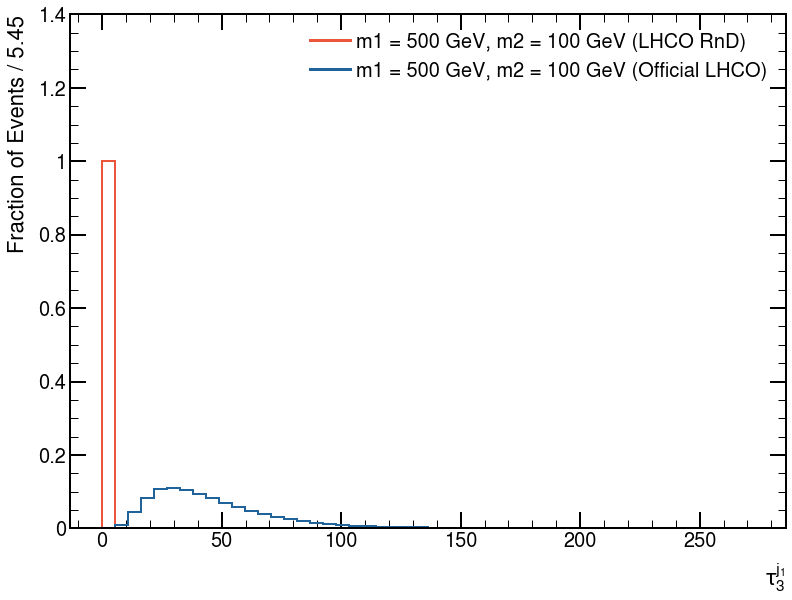

[INFO] Using deduced bin range (0.001, 183.633)


<Figure size 640x480 with 0 Axes>

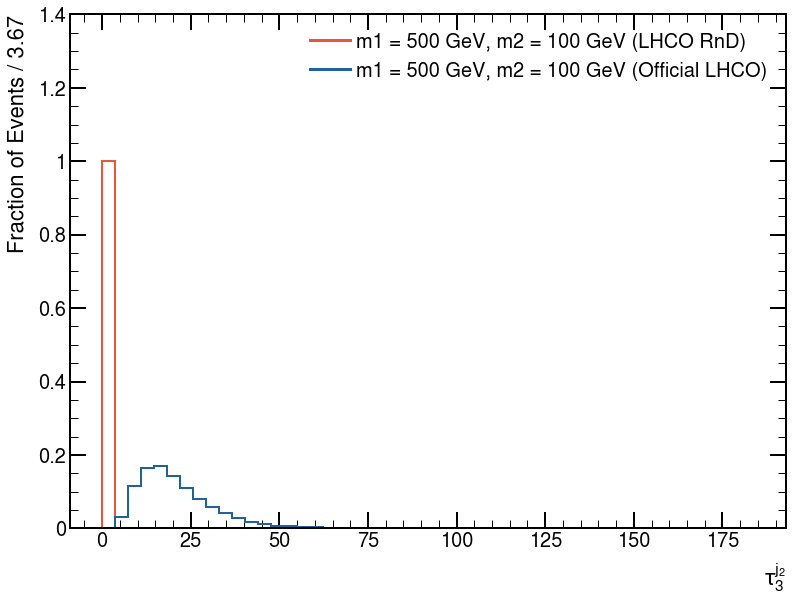

[INFO] Using deduced bin range (0.015, 0.963)


<Figure size 640x480 with 0 Axes>

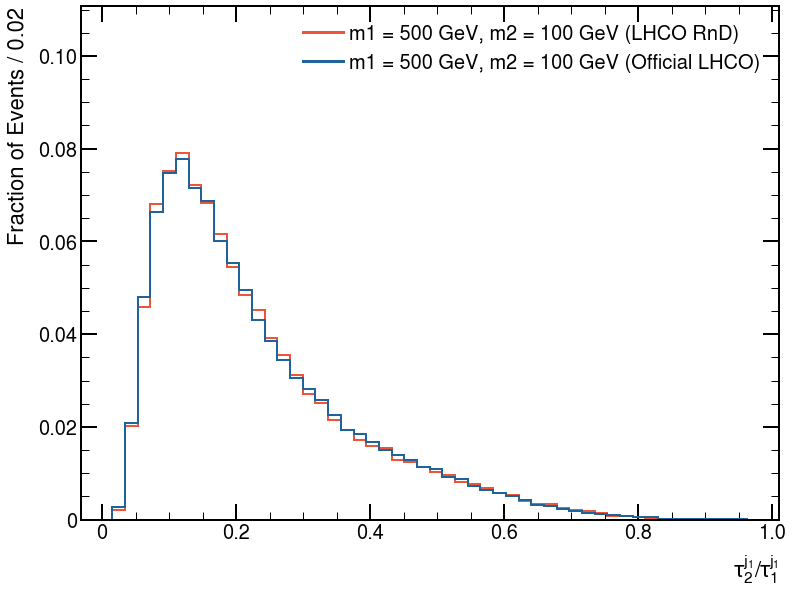

[INFO] Using deduced bin range (0.008, 0.979)


<Figure size 640x480 with 0 Axes>

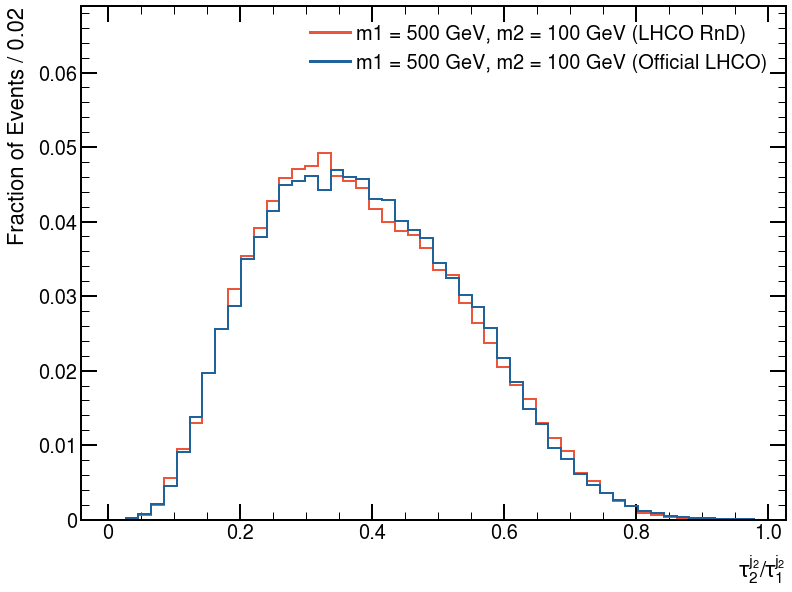

[INFO] Using deduced bin range (0.035, 0.994)


<Figure size 640x480 with 0 Axes>

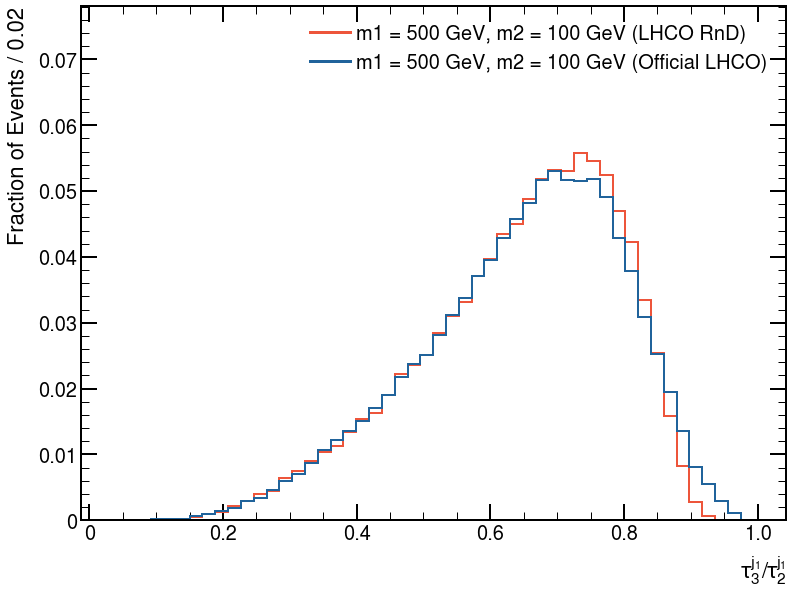

[INFO] Using deduced bin range (0.041, 0.991)


<Figure size 640x480 with 0 Axes>

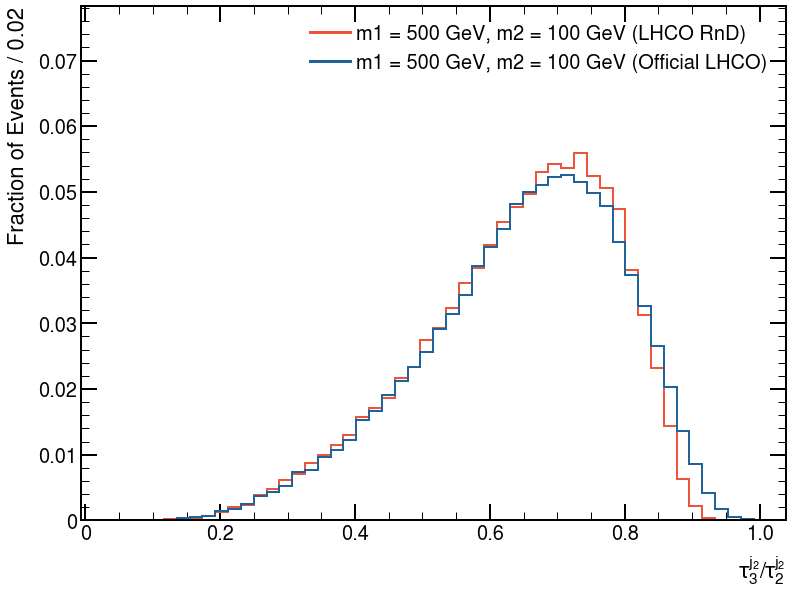

In [44]:
from quickstats.plots import VariableDistributionPlot
import matplotlib.pyplot as plt
options = {
    'mjj': {
        'xlabel': '$m_{jj} [GeV]$',
        'bin_range': (2000, 5000),
        'variable_scale': 1000
    },
    'lead_jet_pt': {
        'xlabel': '$p_T^{j_1} [GeV]$',
        'bin_range': (800, 2600),
        'variable_scale': 1000
    },
    'sub_jet_pt': {
        'xlabel': '$p_T^{j_2} [GeV]$',
        'bin_range': (800, 2600),
        'variable_scale': 1000
    },
    'lead_jet_m': {
        'xlabel': '$m^{j_1} [GeV]$',
        'bin_range': (0, 800),
        'variable_scale': 1000
    },
    'sub_jet_m': {
        'xlabel': '$m^{j_2} [GeV]$',
        'bin_range': (0, 800),
        'variable_scale': 1000
    },
    'lead_jet_eta': {
        'xlabel': r'$\eta_{j_1}$'
    },
    'sub_jet_eta': {
        'xlabel': r'$\eta_{j_2}$'
    },
    'lead_jet_phi': {
        'xlabel': r'$\phi_{j_1}$'
    },
    'sub_jet_phi': {
        'xlabel': r'$\phi_{j_2}$'
    },
    'lead_jet_N': {
        'xlabel': '$N_{particle}^{j_1}$'
    },
    'sub_jet_N': {
        'xlabel': '$N_{particle}^{j_2}$'
    },
    'lead_jet_tau1': {
        'xlabel': r'$\tau_1^{j_1}$'
    },
    'sub_jet_tau1': {
        'xlabel': r'$\tau_1^{j_2}$'
    },
    'lead_jet_tau2': {
        'xlabel': r'$\tau_2^{j_1}$'
    },
    'sub_jet_tau2': {
        'xlabel': r'$\tau_2^{j_2}$'
    },
    'lead_jet_tau3': {
        'xlabel': r'$\tau_3^{j_1}$'
    },
    'sub_jet_tau3': {
        'xlabel': r'$\tau_3^{j_2}$'
    },
    'lead_jet_tau12': {
        'xlabel': r'$\tau_2^{j_1}/\tau_1^{j_1}$'
    },
    'sub_jet_tau12': {
        'xlabel': r'$\tau_2^{j_2}/\tau_1^{j_2}$'
    },
    'lead_jet_tau23': {
        'xlabel': r'$\tau_3^{j_1}/\tau_2^{j_1}$'
    },
    'sub_jet_tau23': {
        'xlabel': r'$\tau_3^{j_2}/\tau_2^{j_2}$'
    }
}
label_map = {
    '500_100' : 'm1 = 500 GeV, m2 = 100 GeV',
    '350_350' : 'm1 = 350 GeV, m2 = 350 GeV',
    '50_400'  : 'm1 = 550 GeV, m2 = 50 GeV'
}
plotter = VariableDistributionPlot(dfs, label_map=label_map)
for column in options:
    plotter.draw(column,
                 targets=['500_100', '350_350', '50_400'],
                 #targets=['500_100', '500_100_LHCO'],
                 **options[column],
                 bins=50,
                 normalize=True,
                 ypad=0.25)
    plt.show()
label_map = {
    '500_100' : 'm1 = 500 GeV, m2 = 100 GeV (LHCO RnD)',
    '500_100_LHCO' : 'm1 = 500 GeV, m2 = 100 GeV (Official LHCO)'
}
plotter.label_map = label_map
for column in options:
    plotter.draw(column,
                 targets=['500_100', '500_100_LHCO'],
                 **options[column],
                 bins=50,
                 normalize=True,
                 ypad=0.25)
    plt.show()

<Figure size 640x480 with 0 Axes>

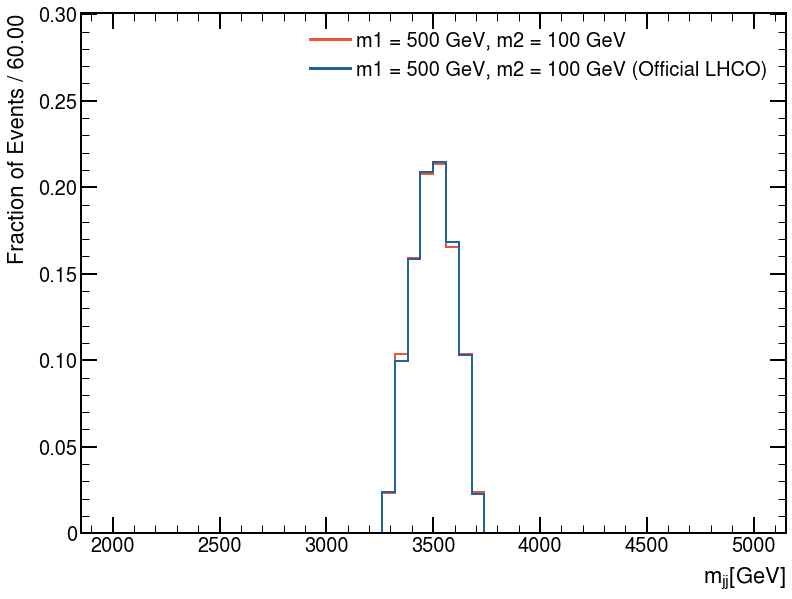

<Figure size 640x480 with 0 Axes>

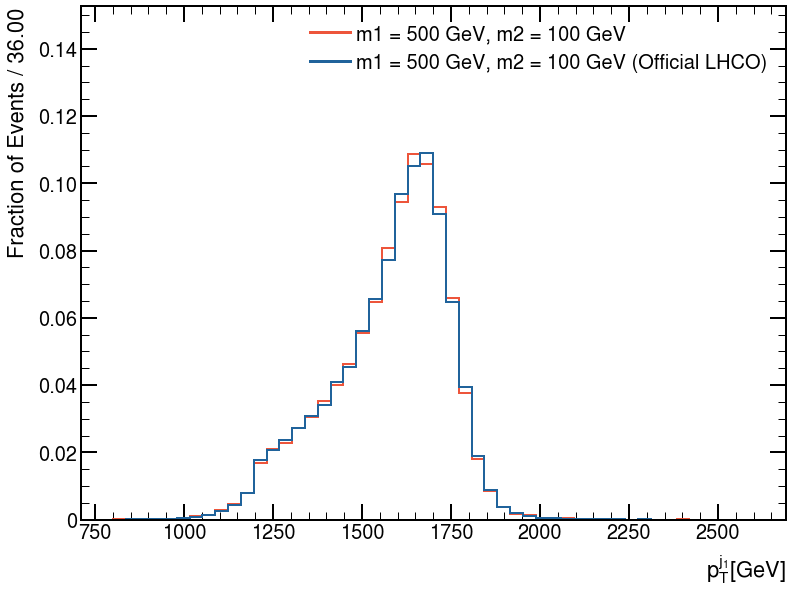

<Figure size 640x480 with 0 Axes>

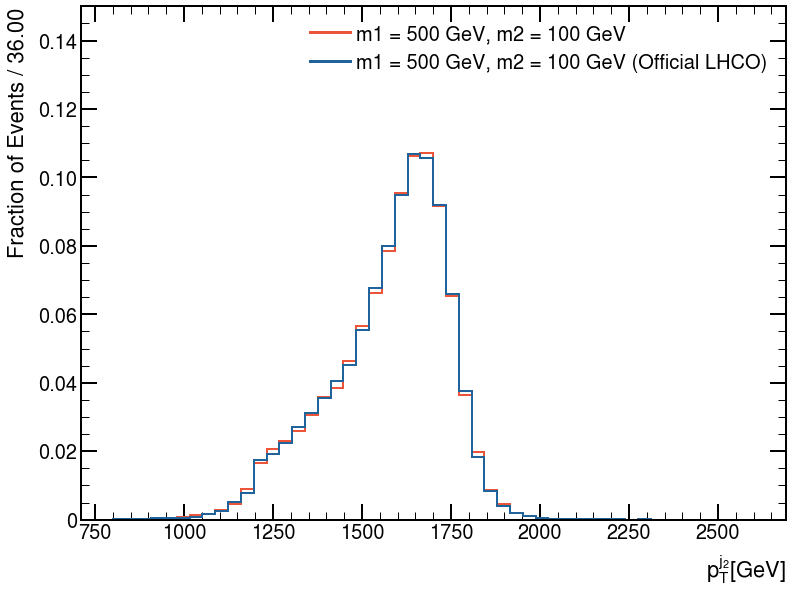

<Figure size 640x480 with 0 Axes>

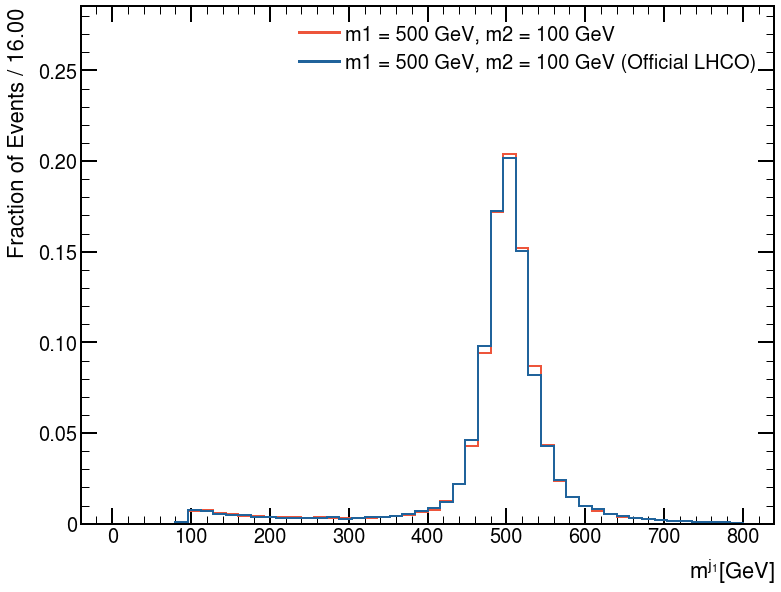

<Figure size 640x480 with 0 Axes>

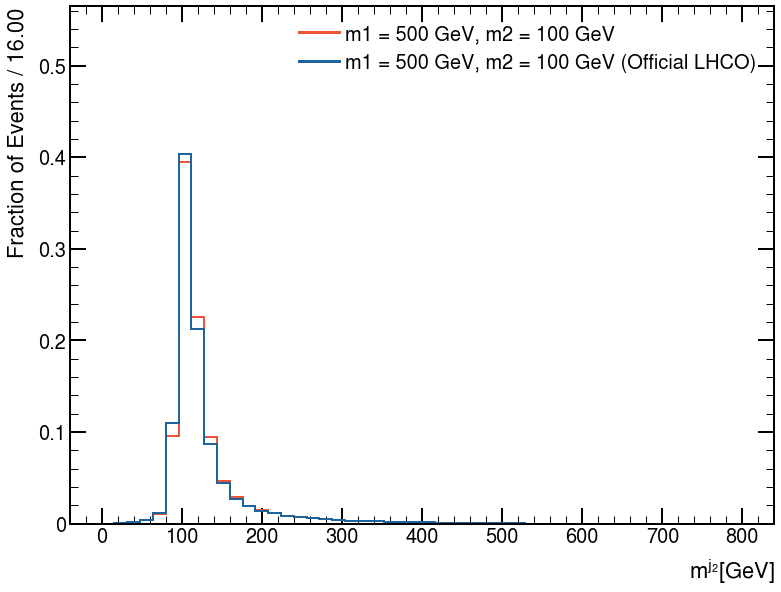

[INFO] Using deduced bin range (-2.134, 2.112)


<Figure size 640x480 with 0 Axes>

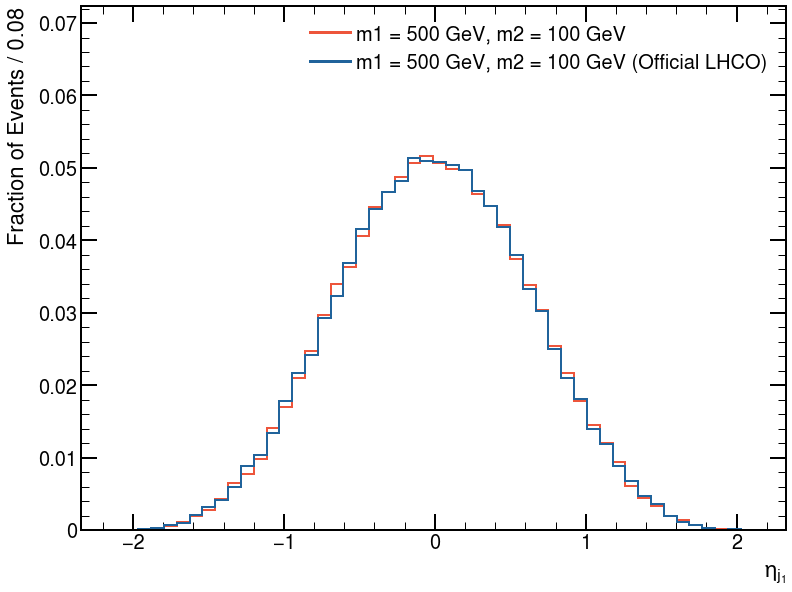

[INFO] Using deduced bin range (-2.326, 2.179)


<Figure size 640x480 with 0 Axes>

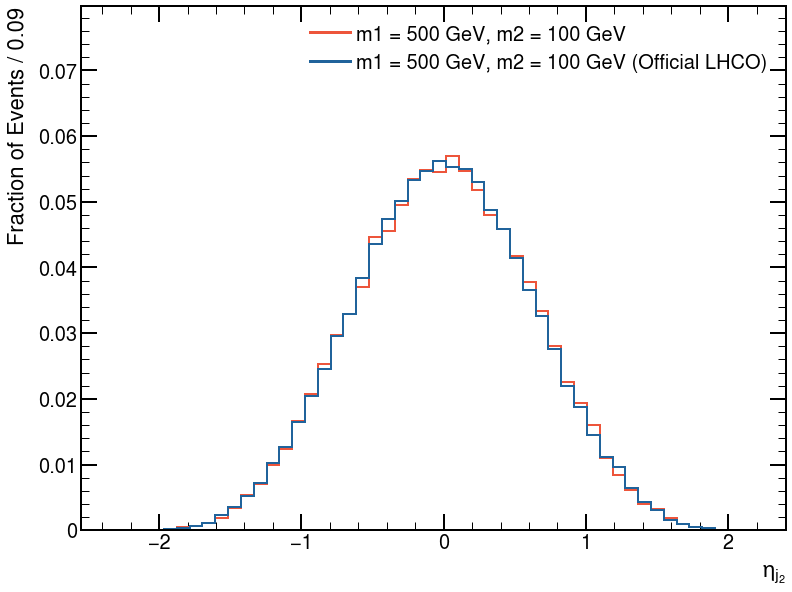

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

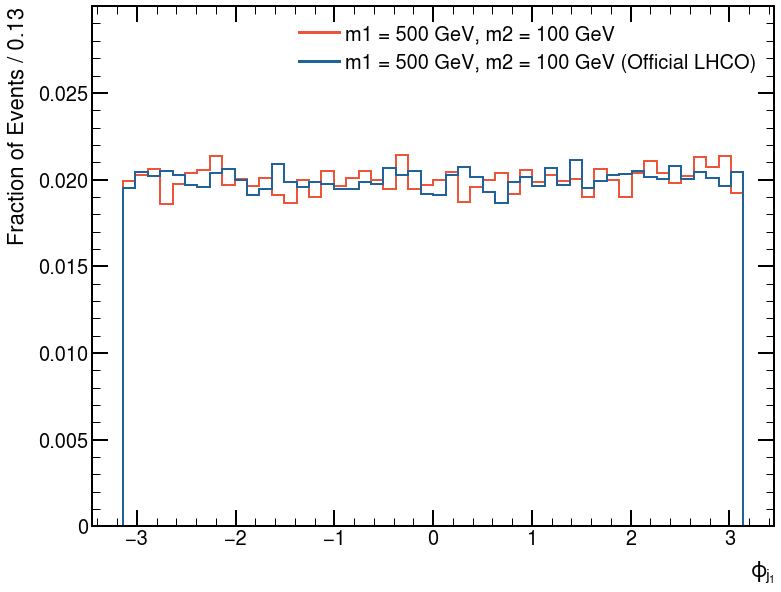

[INFO] Using deduced bin range (-3.142, 3.142)


<Figure size 640x480 with 0 Axes>

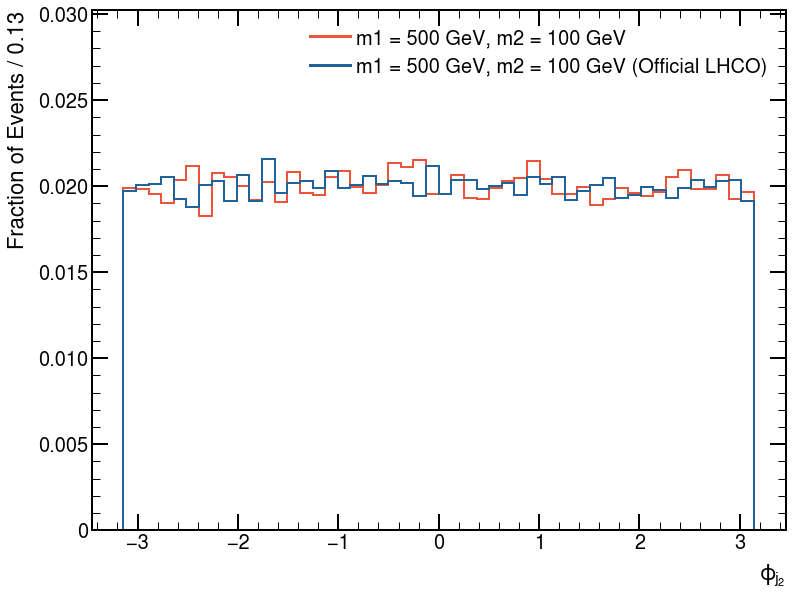

[INFO] Using deduced bin range (12.000, 190.000)


<Figure size 640x480 with 0 Axes>

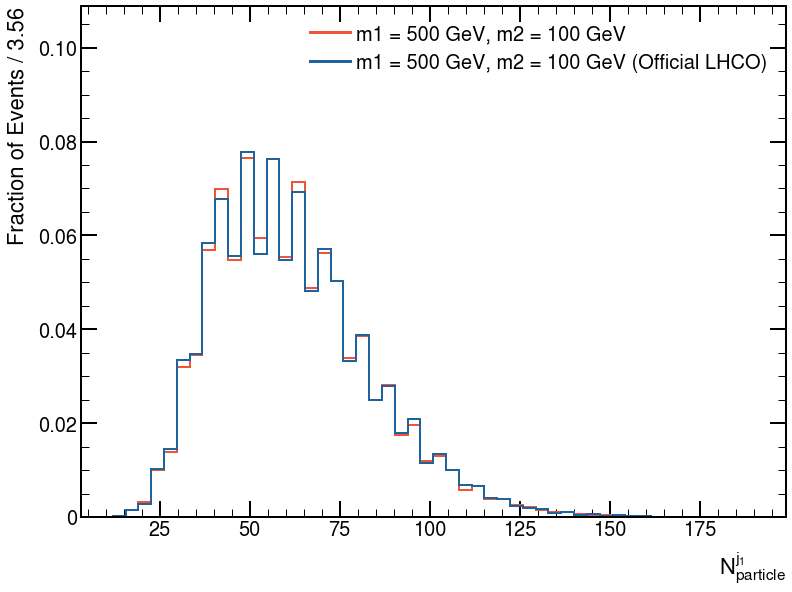

[INFO] Using deduced bin range (4.000, 175.000)


<Figure size 640x480 with 0 Axes>

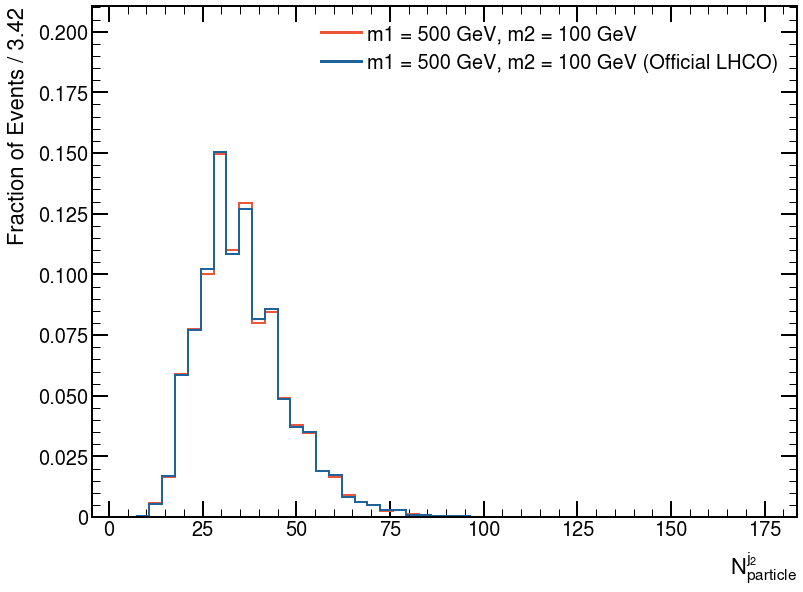

[INFO] Using deduced bin range (0.009, 1151.050)


<Figure size 640x480 with 0 Axes>

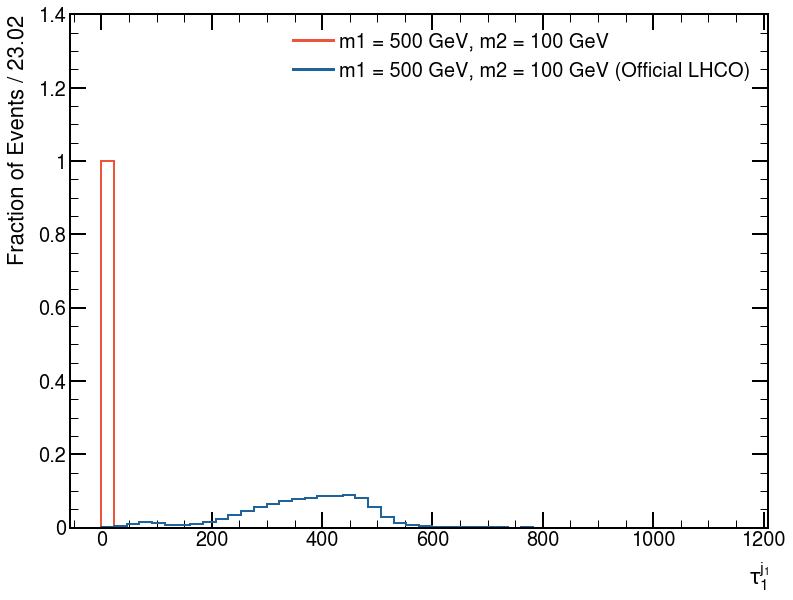

[INFO] Using deduced bin range (0.003, 681.842)


<Figure size 640x480 with 0 Axes>

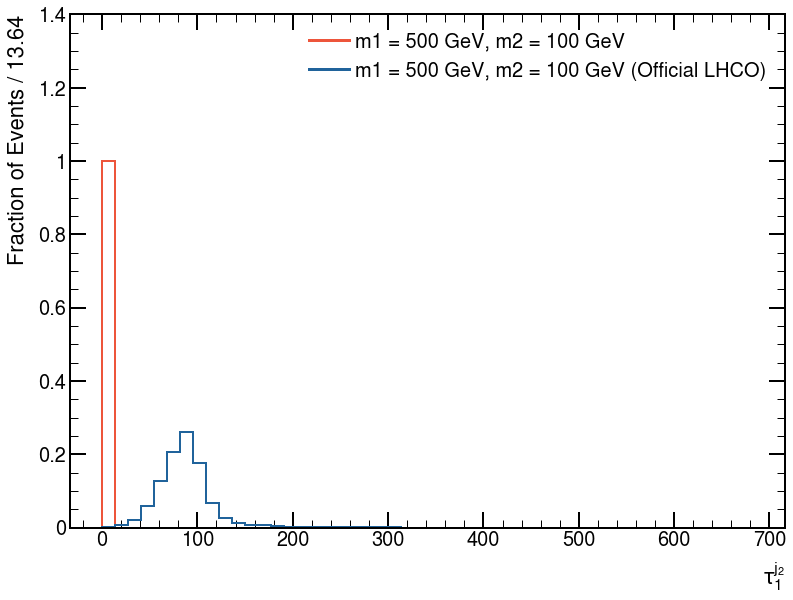

[INFO] Using deduced bin range (0.003, 521.916)


<Figure size 640x480 with 0 Axes>

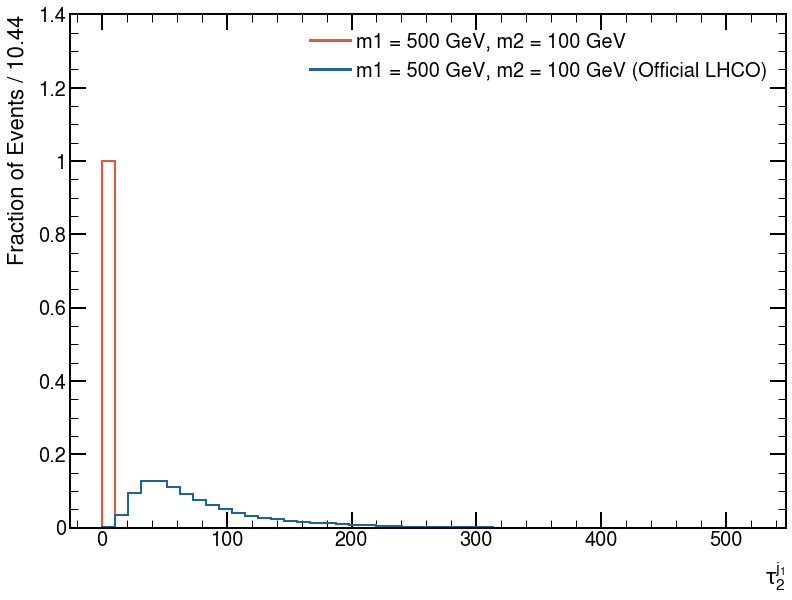

[INFO] Using deduced bin range (0.002, 248.643)


<Figure size 640x480 with 0 Axes>

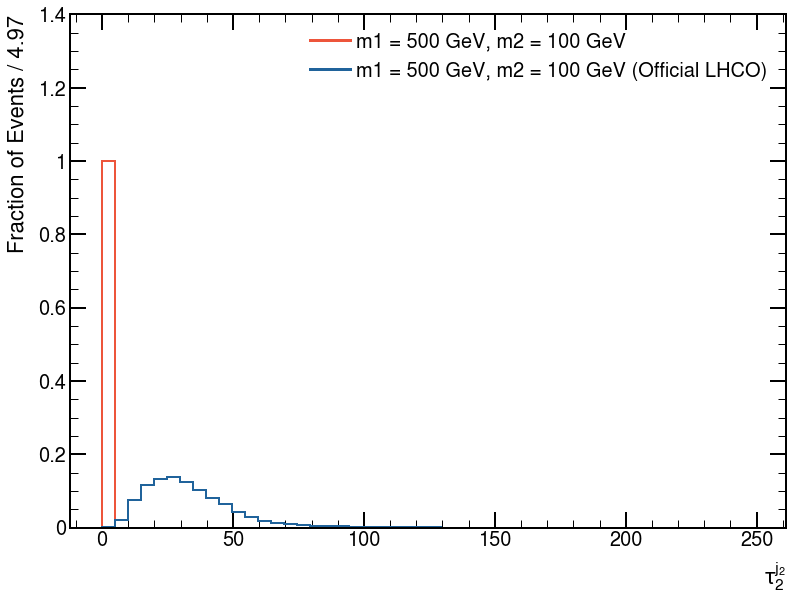

[INFO] Using deduced bin range (0.002, 272.331)


<Figure size 640x480 with 0 Axes>

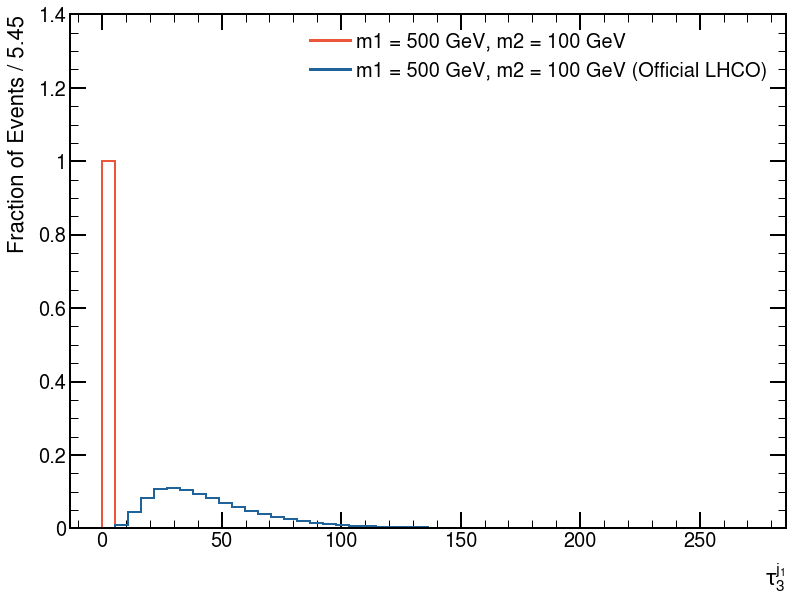

[INFO] Using deduced bin range (0.001, 183.633)


<Figure size 640x480 with 0 Axes>

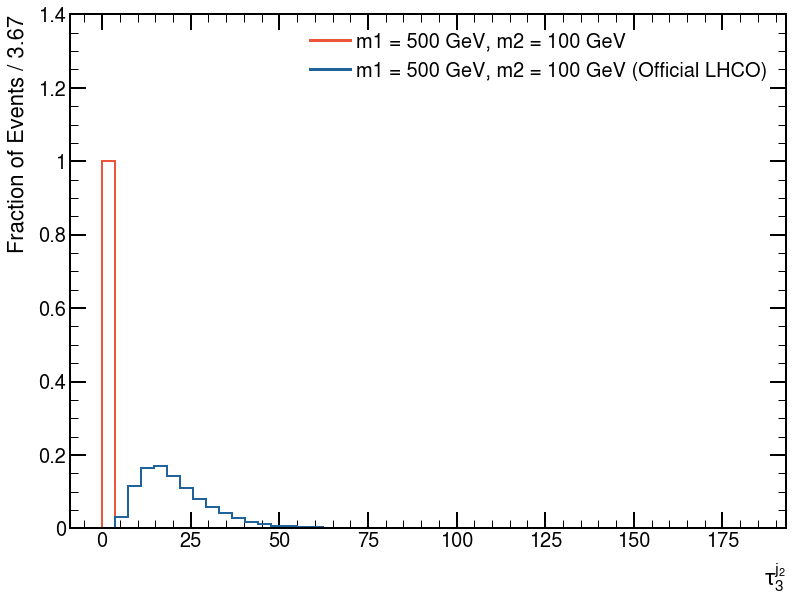

[INFO] Using deduced bin range (0.015, 0.963)


<Figure size 640x480 with 0 Axes>

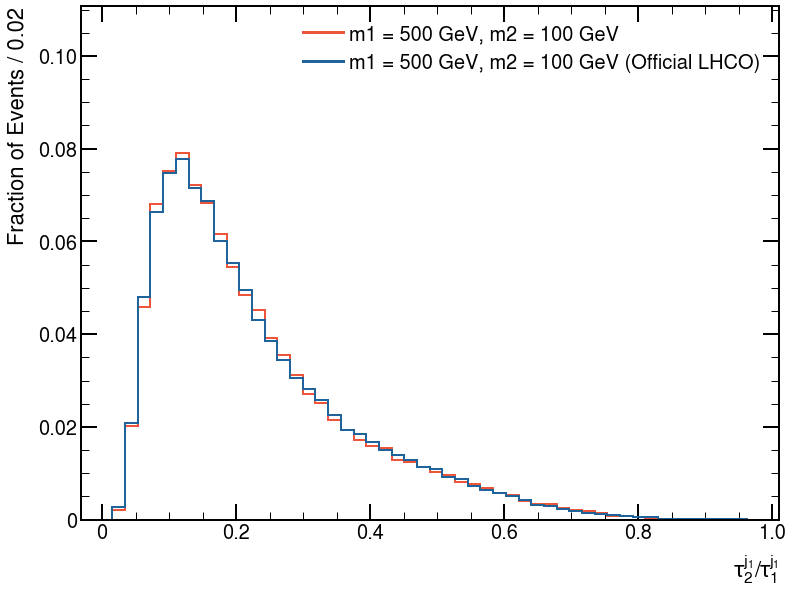

[INFO] Using deduced bin range (0.008, 0.979)


<Figure size 640x480 with 0 Axes>

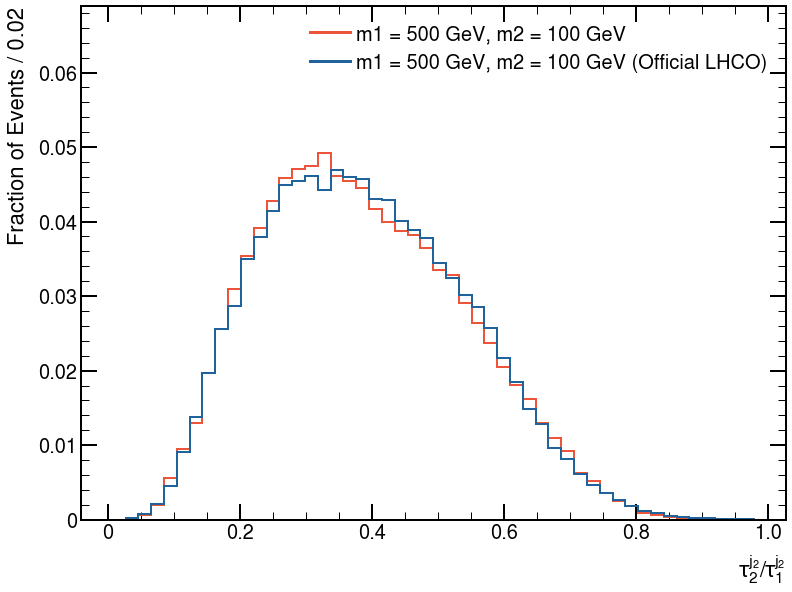

[INFO] Using deduced bin range (0.035, 0.994)


<Figure size 640x480 with 0 Axes>

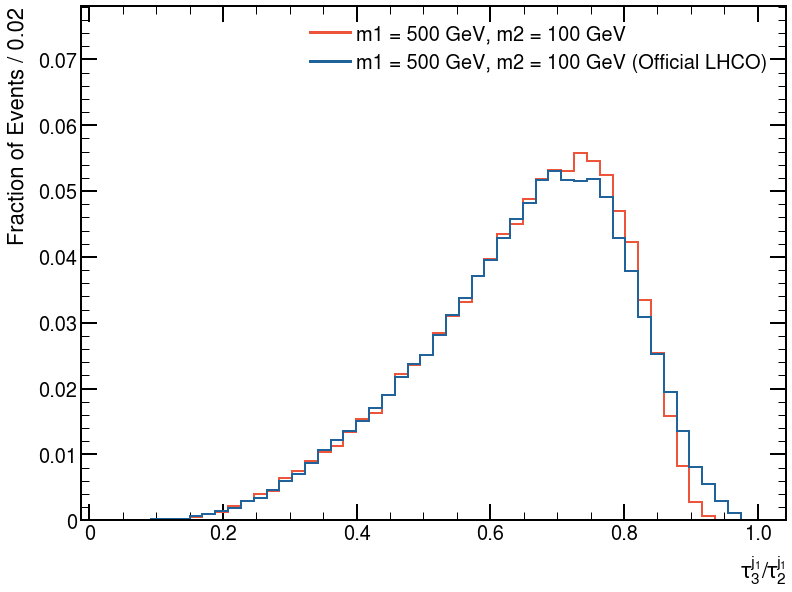

[INFO] Using deduced bin range (0.041, 0.991)


<Figure size 640x480 with 0 Axes>

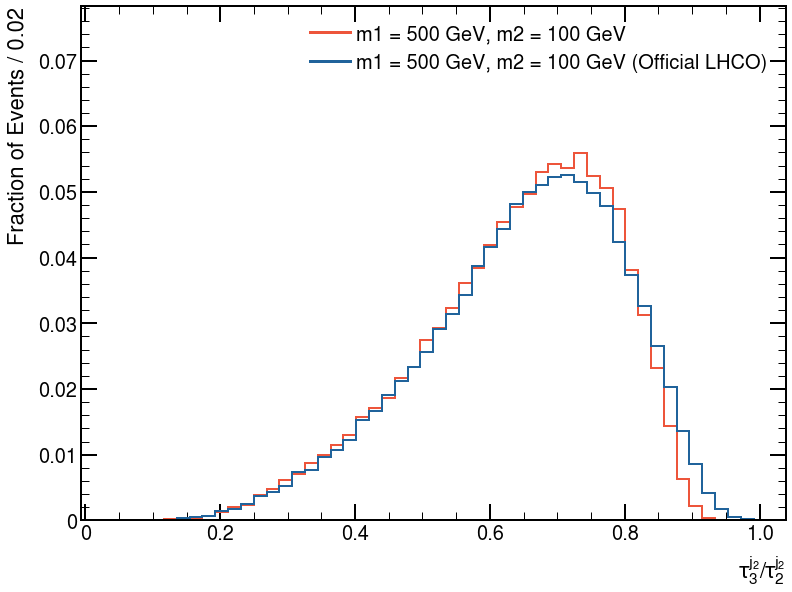

In [28]:
for column in options:
    plotter.draw(column,
                 targets=['500_100', '500_100_LHCO'],
                 **options[column],
                 bins=50,
                 normalize=True,
                 ypad=0.25)
    plt.show()